# This pipeline runs spatial analysis for 10X visium data
## Prepare pipeline environment
To run this pipline, we recommend to use the docker contianer. That page describes how to run the pipeline using docker. If you are using HPC, then it's recommended to run this pipeline using singularity. You can download the docker image using singularity with the command: <br/> 
> **singularity pull docker://shl198/sc_ppl:202306**. <br/>

Singularity image file is not writable, you can transfer it to a sandbox and then you will be able to install packages inside it without administrator role. The commands are:
> singularity build --sandbox sc_pipeline/ sc_ppl.sif <br/>
> singularity run -w sc_pipeline jupyter-lab --no-browser --port 8887

In the end, you can open jupyter-lab by copying and pasting the url shown in terminal.

# 0. Load packages

In [1]:
import scanpy as sc
import anndata as ad
import squidpy as sq
import scanorama
import math
import sys

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from bioinfokit import visuz

import numpy as np
import pandas as pd
import glob
import os

import warnings
warnings.filterwarnings("ignore")

import stlearn as st

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
sys.path.insert(1, os.path.join(sys.path[0], '..'))

2023-05-31 23:01:13.627707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 23:01:15.045308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64/lib:/.singularity.d/libs
2023-05-31 23:01:15.045555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /hpc/grid/lsfhpcprod/10.1/linux3.10-glibc2.17-x86_64

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.6 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10
squidpy==1.2.3


In [2]:
# each time you modified the code in utils folder, you need to run this chunk to refresh the loading
import importlib
import utils.visium_modules as vis
importlib.reload(vis)

<module 'utils.visium_modules' from '/home/lis262/Code/scRNASeq_spatial/spatial_pipeline/projects/../utils/visium_modules.py'>

## !!! Attention before loading the files
in the cellranger output folder, there's a sub folder called spatial. Inside the spatial folder, there's a file called **tissue_positions.csv**, please change the file name to **tissue_positions_list.csv**, then open this file and remove the header if there is one in the file.

# 1. Preprocessing
## 1.1 Load data

In [3]:
path = '/media/hpc/grid/wip_drm_targetsciences/projects/p051_senescence_esf'
work_path = f'{path}/p01_visium_20220819/Analysis'
raw_path = f'{work_path}/f01_raw'
file_pres = [f for f in sorted(glob.glob(f'{raw_path}/*')) if os.path.isdir(f)]

sasp_gene_fn = f'{path}/senecense_SASP.txt'
sasp_genes = pd.read_csv(sasp_gene_fn,header=None)[0].to_list()
senmyo_gene_fn = f'{path}/senmyo.txt'
senmyo_genes = pd.read_csv(senmyo_gene_fn,header=None)[0].to_list()
fibro_gene_fn = f'{path}/fibro_genes.txt'
fibro_genes = pd.read_csv(fibro_gene_fn,header=None)[0].to_list()

In [4]:
adata_list, samples = vis.get_adata_list(file_pres)

## 1.2 Plot QC plots
Distribution of total_counts, distribution of n_genes_by_counts(The number of genes with at least 1 count in a cell)

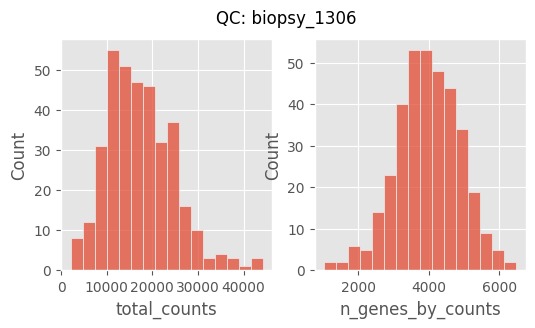

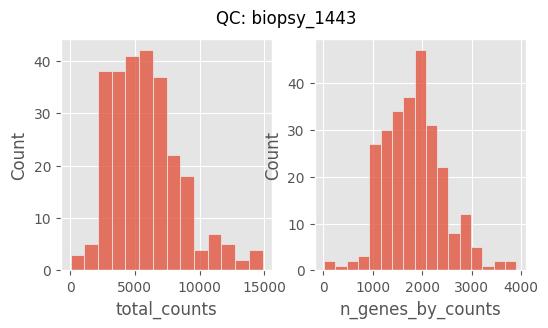

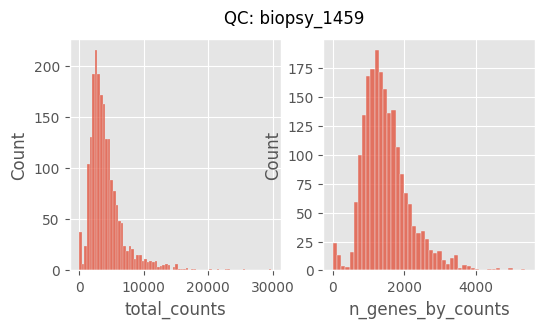

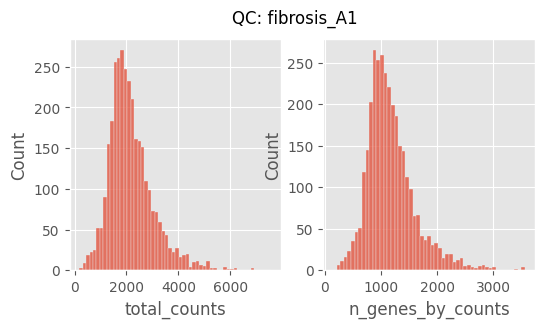

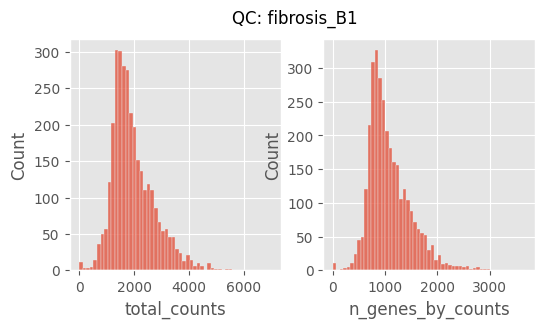

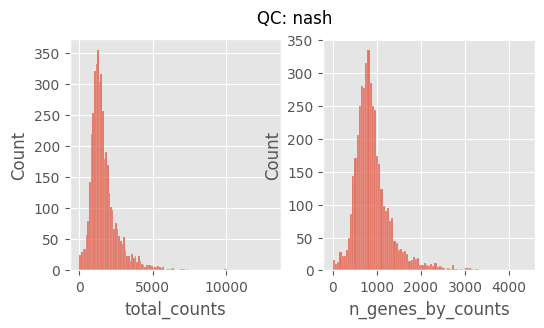

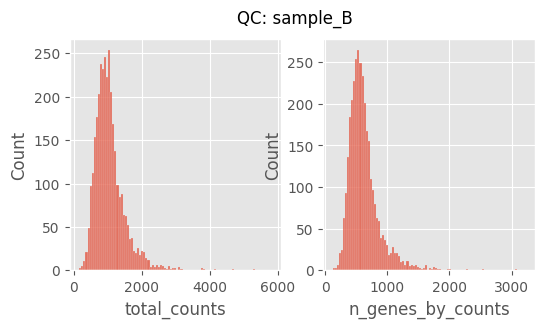

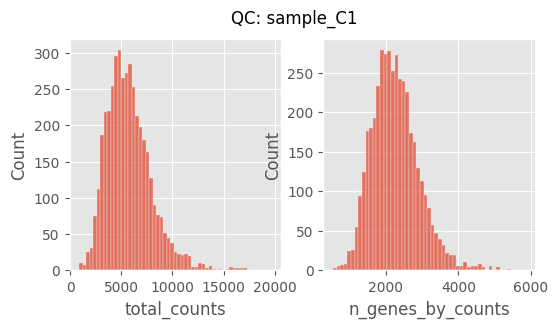

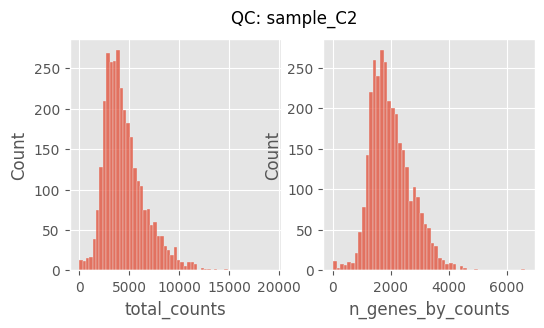

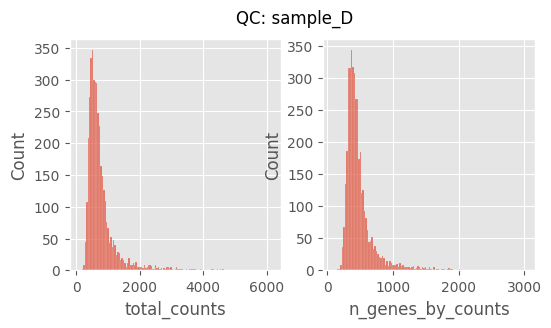

In [5]:
for sp, ad in zip(samples, adata_list):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    fig.suptitle(f"QC: {sp}")
    sns.histplot(ad.obs["total_counts"], kde=False, ax=axs[0])
    sns.histplot(ad.obs["n_genes_by_counts"], kde=False, ax=axs[1])
    # axs[0].set_ylim(0,350)
    # axs[1].set_ylim(0,350)
    # sns.histplot(ad.obs["n_genes_by_counts"][ad.obs["n_genes_by_counts"]<1000], kde=False, ax=axs[3])

## 1.3 Normalize each sample separately

In [6]:
vis.norm_hv_gene(adata_list)

# 2 Integrate data clustering

## 2.1 Integrate data using scanorama

In [8]:
# adata_list = adata_list[2:5] + adata_list[0:2]
adatas_cor = scanorama.correct_scanpy(adata_list, return_dimred=True)

Found 11076 genes among all datasets
[[0.         0.33147632 0.1810585  0.         0.         0.
  0.         0.10027855 0.00278552 0.        ]
 [0.         0.         0.43609023 0.0075188  0.0112782  0.0075188
  0.         0.01879699 0.0075188  0.        ]
 [0.         0.         0.         0.010279   0.01076848 0.47185512
  0.00342633 0.00636319 0.00538424 0.00783162]
 [0.         0.         0.         0.         0.84048507 0.00593472
  0.01733577 0.00589067 0.00996264 0.        ]
 [0.         0.         0.         0.         0.         0.0164346
  0.26246959 0.02214892 0.01867995 0.0096393 ]
 [0.         0.         0.         0.         0.         0.
  0.02159367 0.00094251 0.01214197 0.49528068]
 [0.         0.         0.         0.         0.         0.
  0.         0.00447691 0.00973236 0.04957421]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.49657534 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.  

In [9]:
adata_spatial = sc.concat(adatas_cor, label="library_id", uns_merge="unique",
    keys=[k for d in [ad.uns['spatial'] for ad in adatas_cor] for k, v in d.items()], index_unique="-",)
adata_spatial.raw = adata_spatial

In [10]:
adata_spatial.obs['sample'].value_counts()

nash           4381
sample_C1      4244
sample_D       4026
sample_B       3288
fibrosis_A1    3271
fibrosis_B1    3216
sample_C2      3212
biopsy_1459    2043
biopsy_1306     359
biopsy_1443     266
Name: sample, dtype: int64

## 2.2 Clustering and UMAP
Using leiden method on scanorama embeddings

In [14]:
sc.pp.neighbors(adata_spatial, use_rep="X_scanorama")
sc.tl.umap(adata_spatial)
sc.tl.leiden(adata_spatial, key_added="clusters", resolution=1)

In [18]:
# !!! load the stored data to replicate the results, if you are running for a new dataset, skip this chunk of code.
adata_spatial = sc.read_h5ad(f'{work_path}/sene_adata.h5ad')
adata_spatial.uns['log1p']['base'] = None

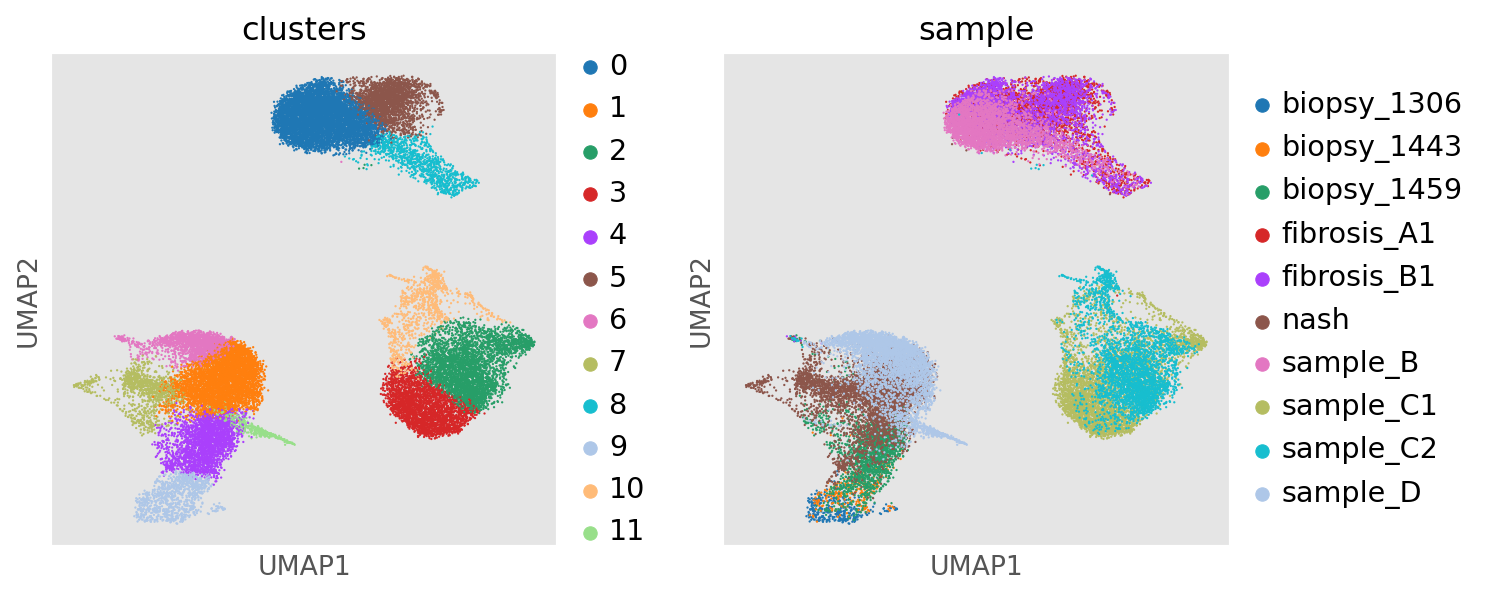

In [19]:
sc.set_figure_params()
plt.style.use('ggplot')
sc.pl.umap(adata_spatial, color=["clusters", "sample"], palette=sc.pl.palettes.default_20)

In [20]:
clusters_colors = dict(zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"]))

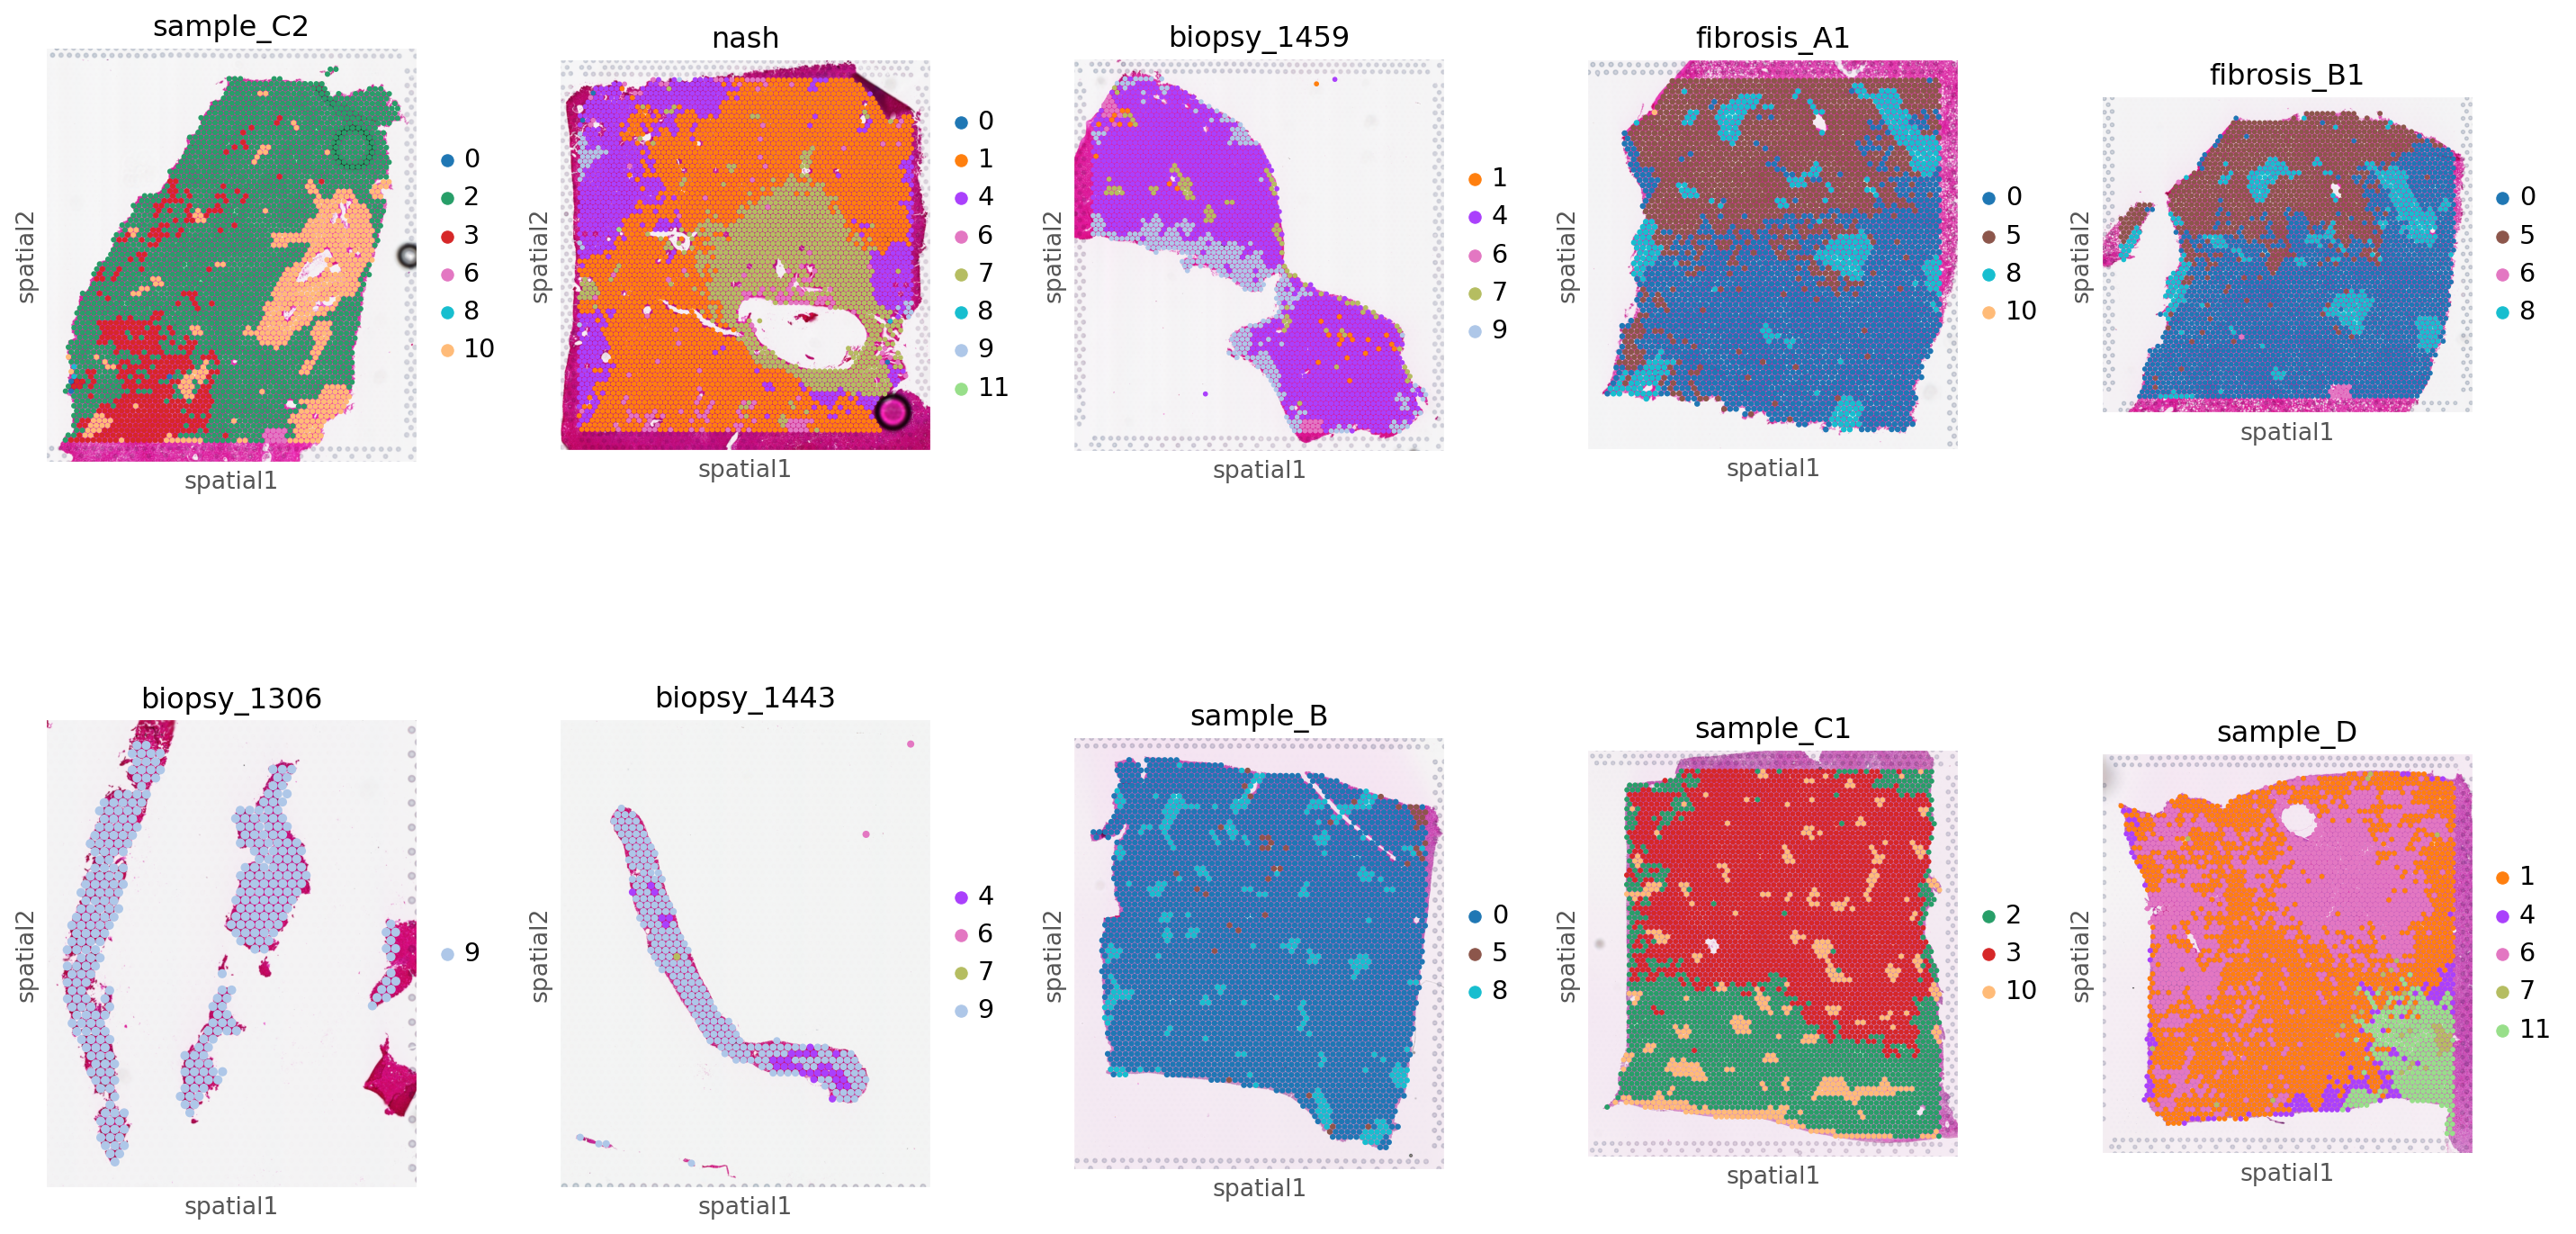

In [21]:
ncol = 5
fig, axs = plt.subplots(math.ceil(len(adatas_cor)/ncol), ncol, figsize=(18, 10))
lib_sp_dict = adata_spatial.obs.set_index('library_id')['sample'].to_dict()
for i, library in enumerate(adata_spatial.uns['spatial'].keys()):
    col = i % ncol
    row = i // ncol
    ad = adata_spatial[adata_spatial.obs.library_id == library, :].copy()
    sc.pl.spatial(ad, img_key="hires", library_id=library, color="clusters", size=1.5, title=lib_sp_dict[library],
                  palette=[v for k, v in clusters_colors.items() if k in ad.obs.clusters.unique().tolist()],
        show=False, ax=axs[row, col])
plt.tight_layout()

In [22]:
print('number of cell in each cluster')
adata_spatial.obs['clusters'].value_counts()

number of cell in each cluster


0     6491
1     4555
2     3714
3     2774
4     2531
5     2244
6     1641
7     1070
8     1035
9      990
10     952
11     309
Name: clusters, dtype: int64

In [23]:
sc.tl.rank_genes_groups(adata_spatial, groupby='clusters')

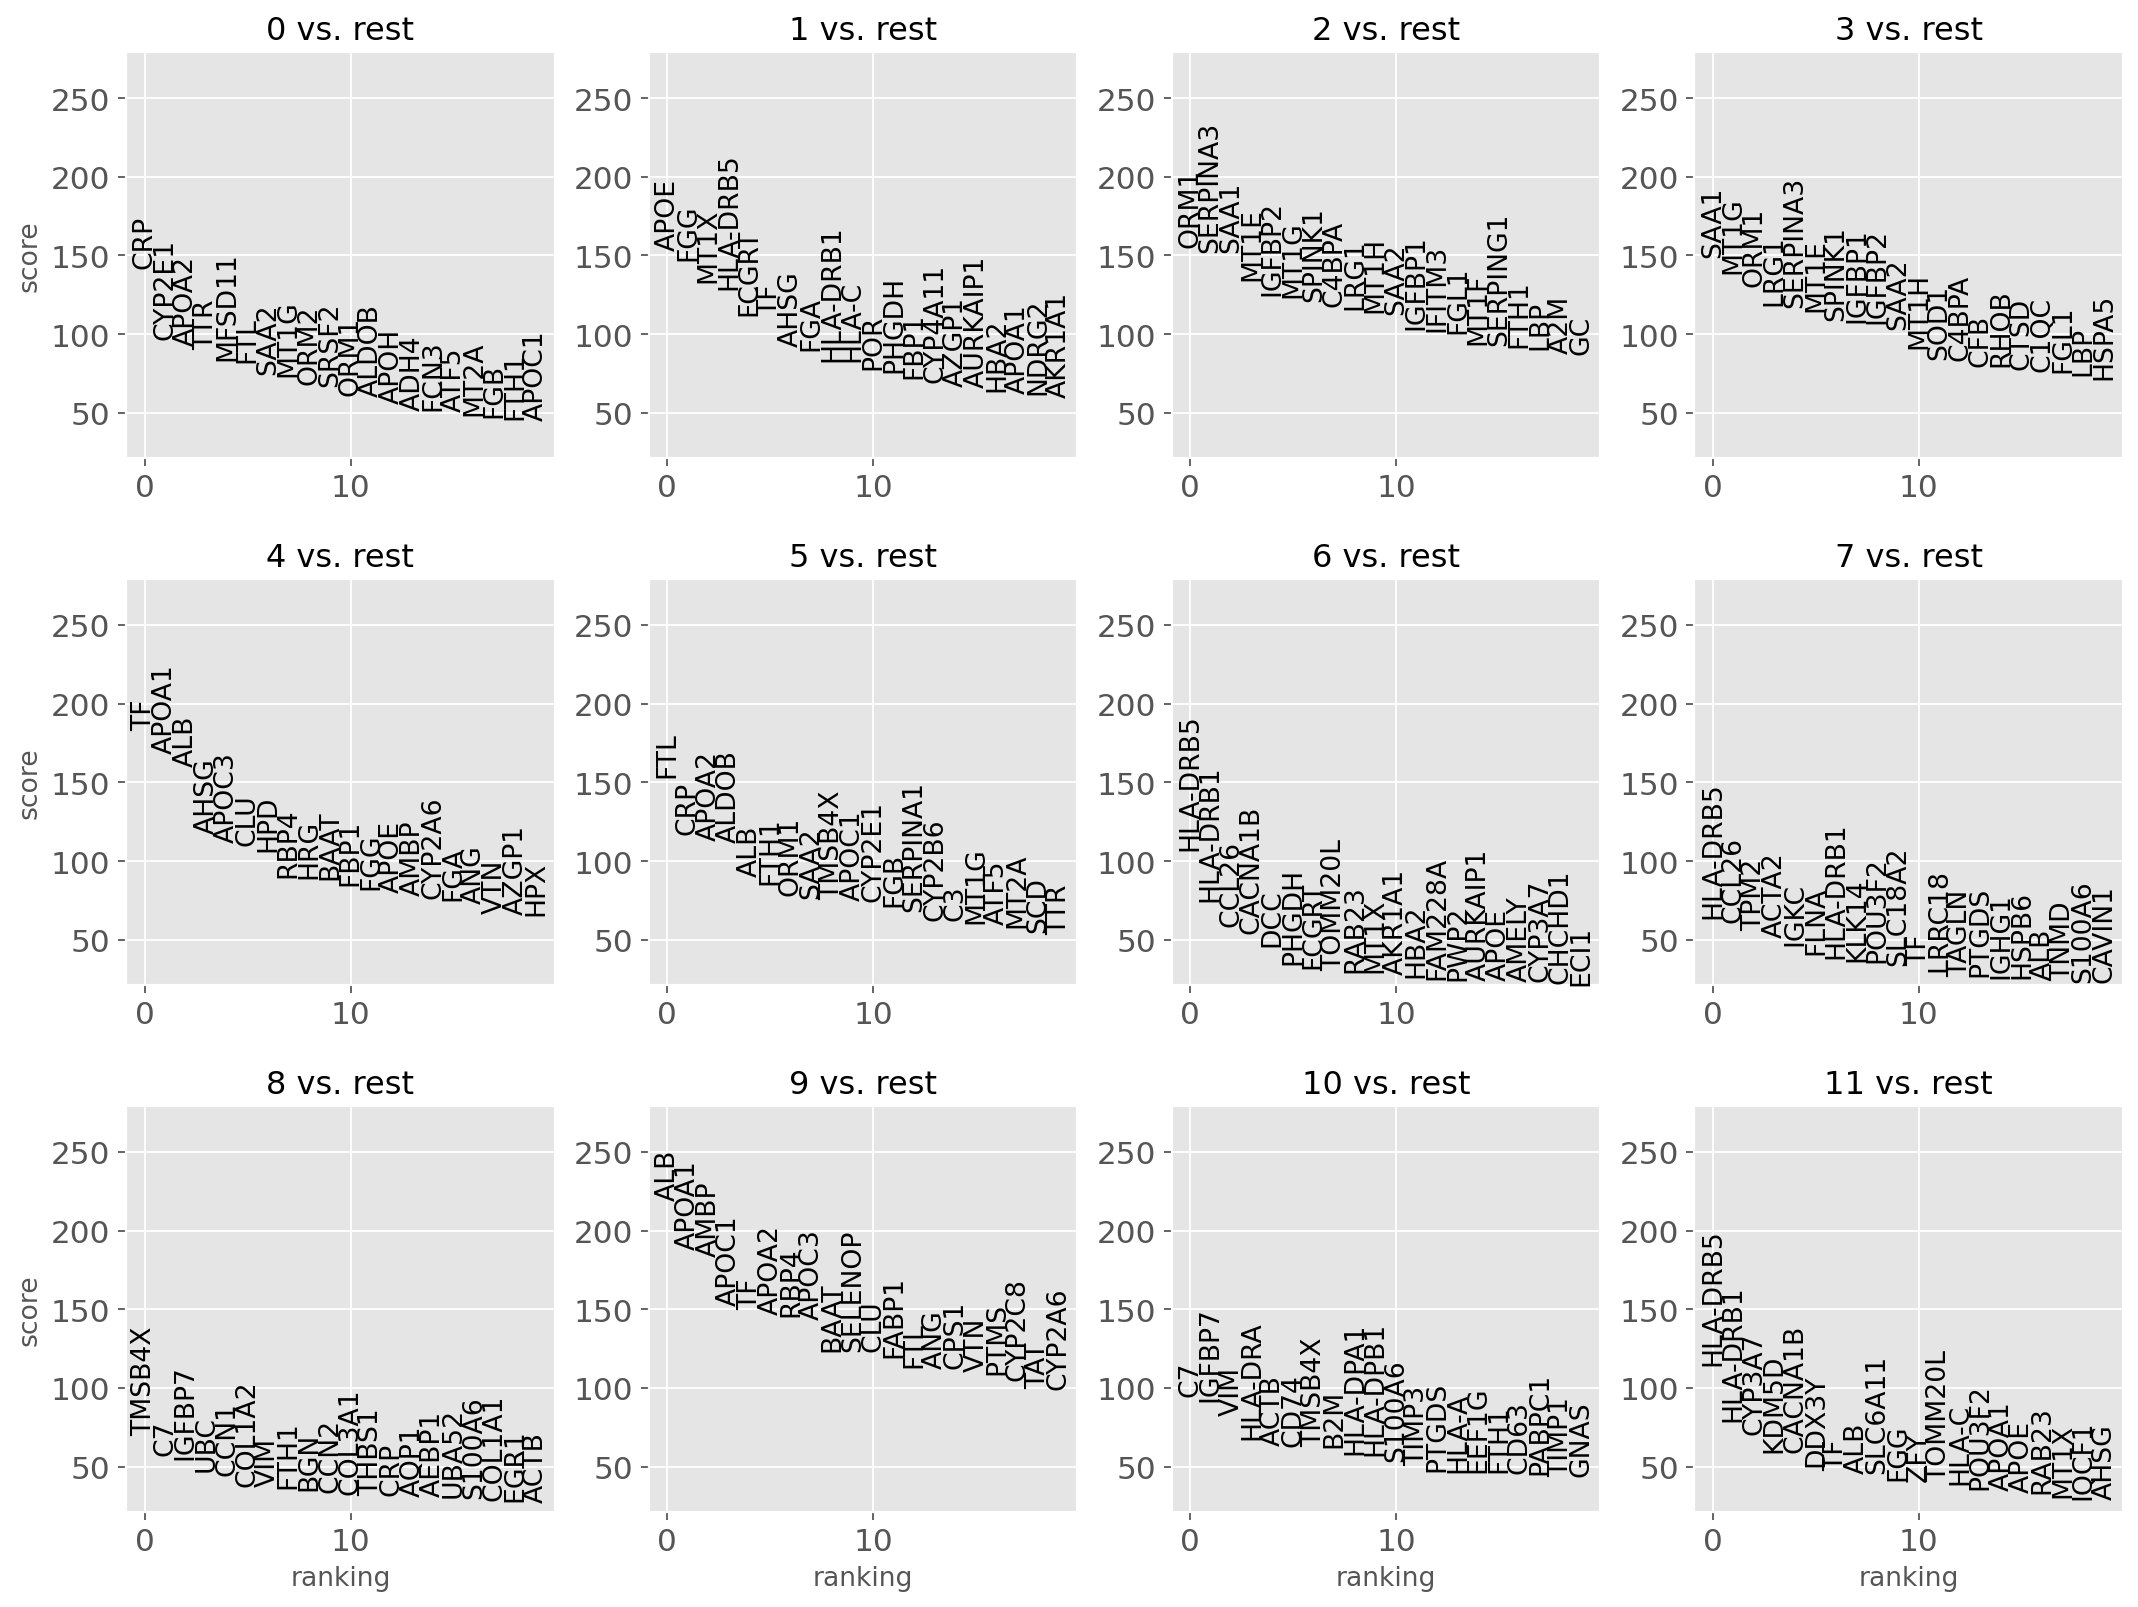

In [19]:
sc.pl.rank_genes_groups(adata_spatial, fontsize=12)

## 2.3 Determine fibrotic levels for clusters

In [24]:
# check fibrotic genes for each cluster
fibro_genes = list(set(fibro_genes).intersection(adata_spatial.var.index.tolist()))
sc.tl.dendrogram(adata_spatial, groupby='clusters', use_rep='X_scanorama')
adata_spatial.layers['scaled'] =  sc.pp.scale(adata_spatial.X)

In [25]:
# extract adata that only has fibrotic genes
fibro_adata = adata_spatial[:,fibro_genes].copy()
sc.tl.dendrogram(fibro_adata, groupby='clusters', use_rep='X_scanorama')

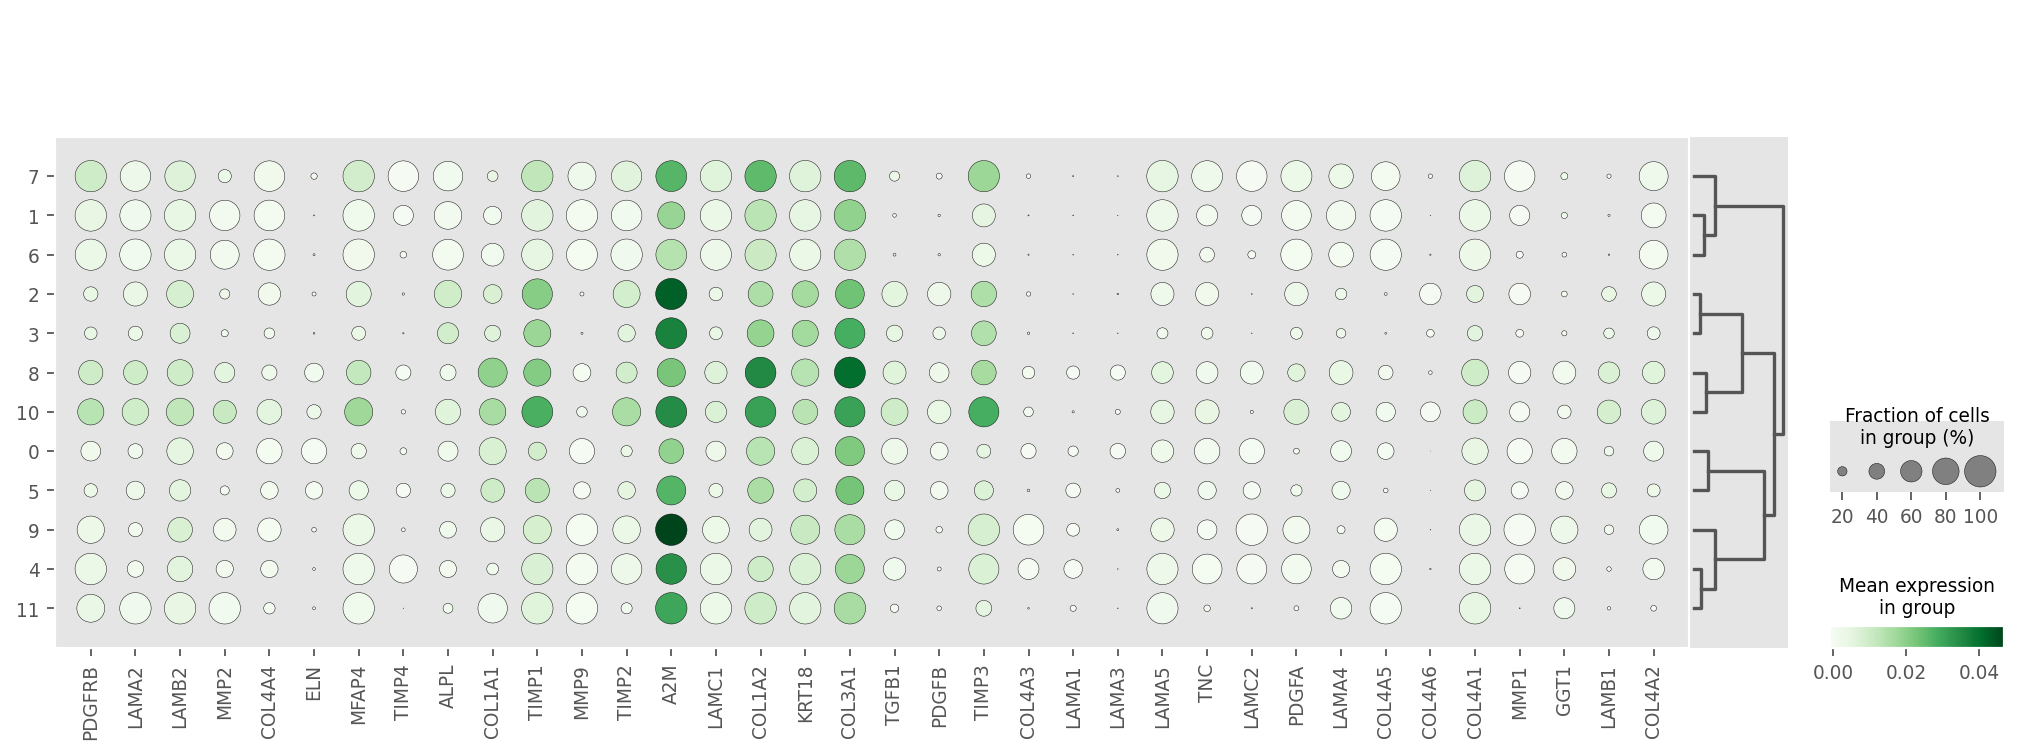

In [26]:
sc.pl.dotplot(fibro_adata, fibro_genes, 'clusters', dendrogram=True, cmap='Greens')

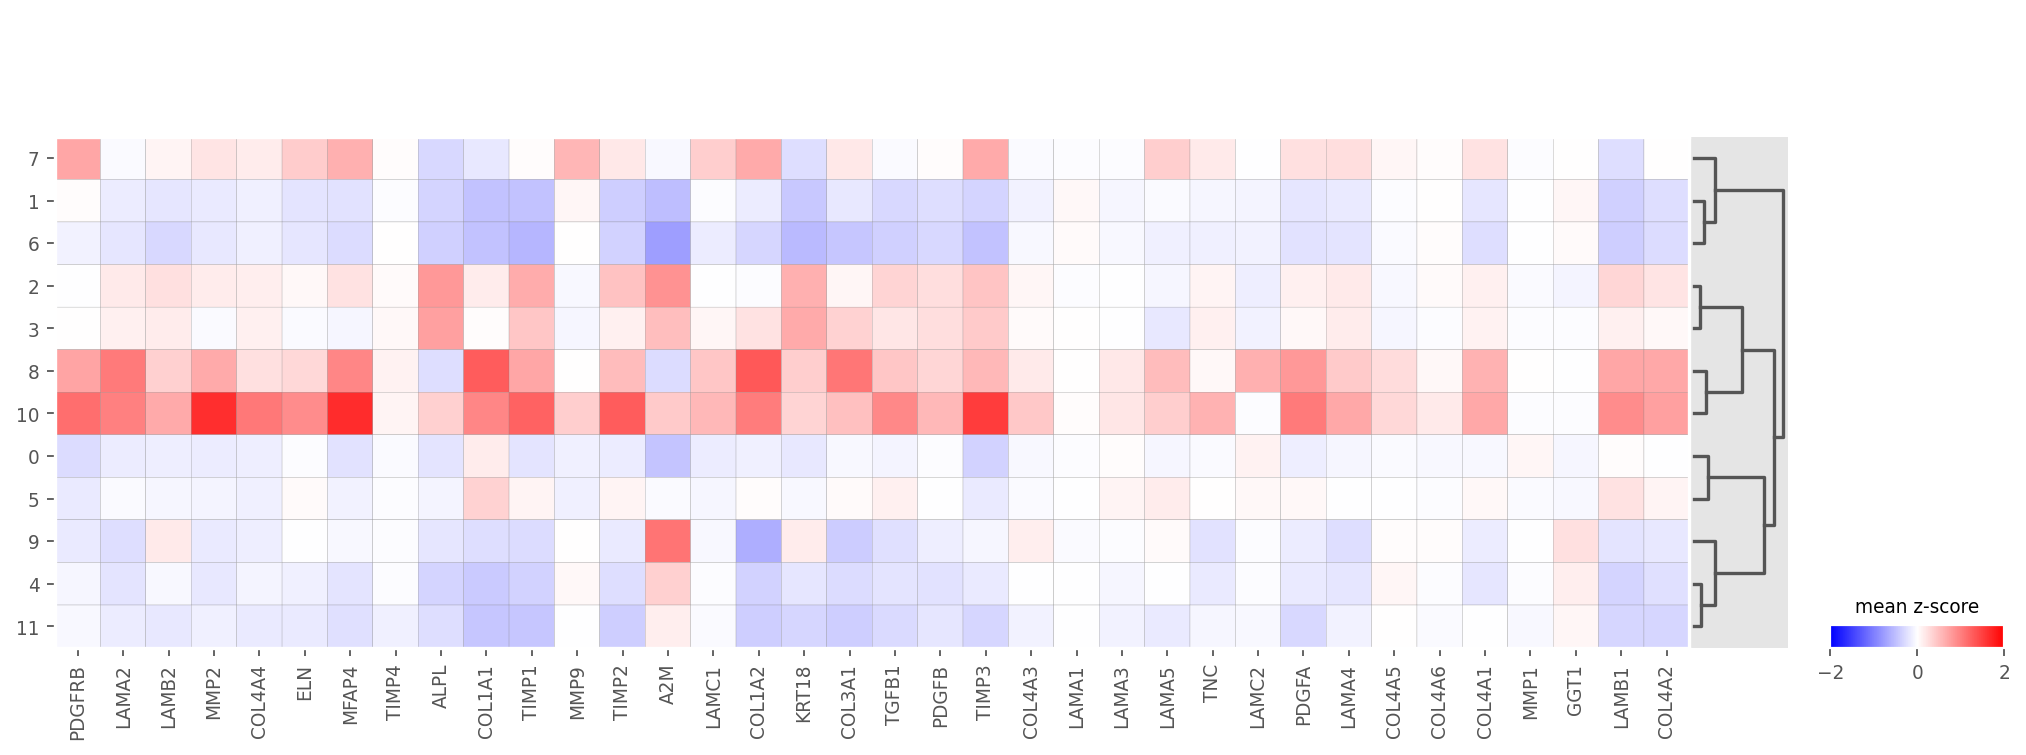

In [27]:
sc.pl.matrixplot(fibro_adata, fibro_genes, 'clusters', cmap='bwr', layer='scaled', colorbar_title='mean z-score', vmin=-2, vmax=2, dendrogram=True)

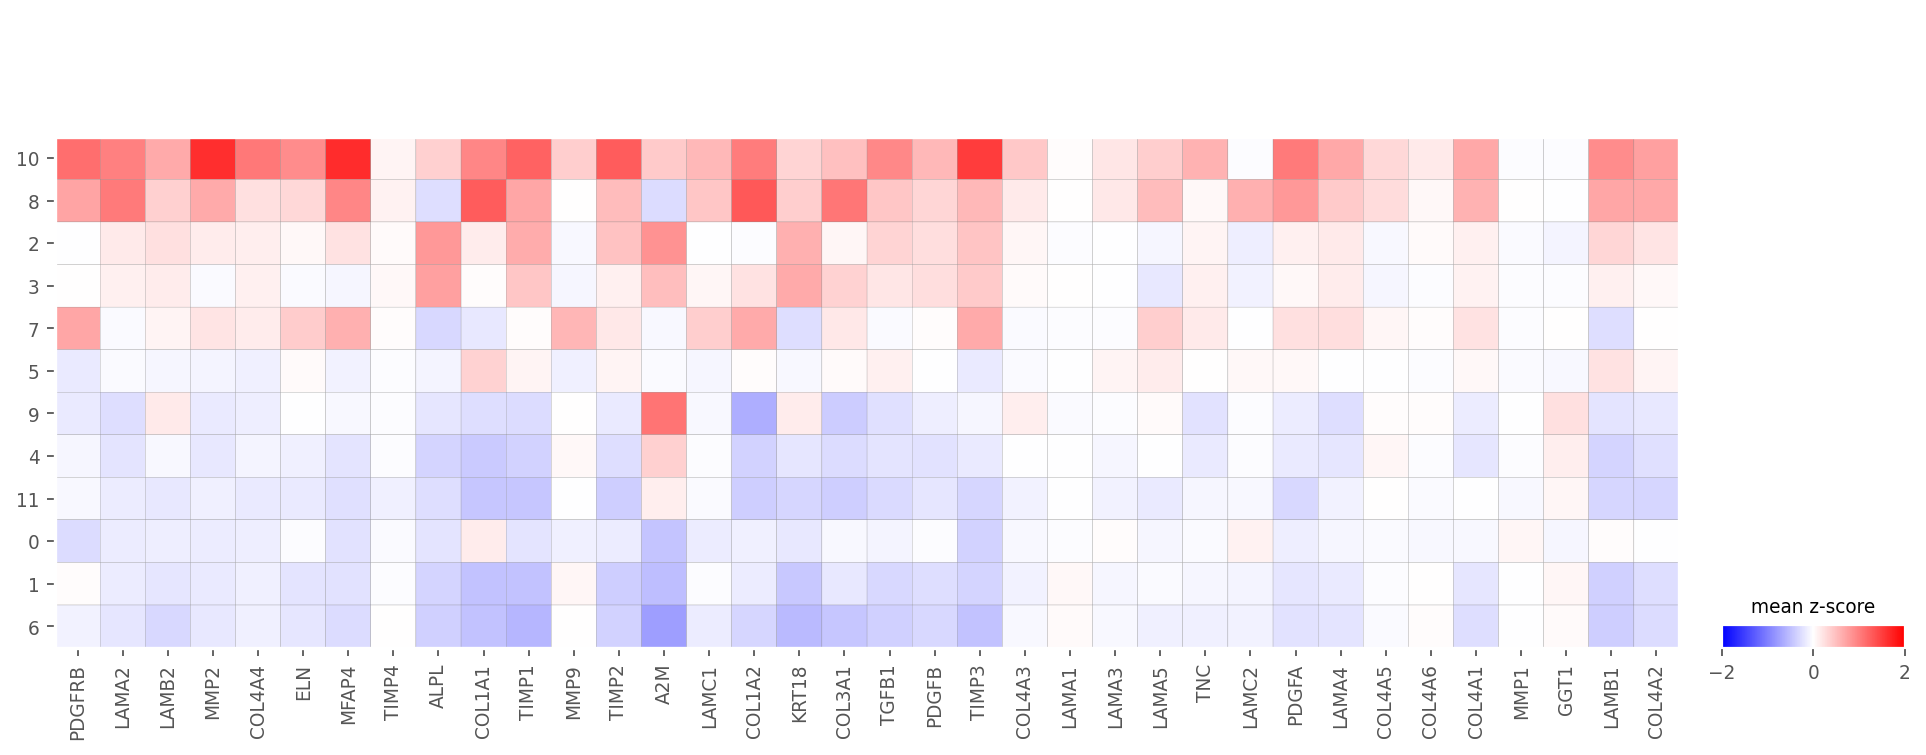

In [28]:
# this chunk of code is to show heatmap using user defined cluster orders.
sc.pl.MatrixPlot.DEFAULT_COLOR_LEGEND_TITLE = 'mean z-score'
sc.pl.MatrixPlot.DEFAULT_COLORMAP= 'bwr'
sc.pl.MatrixPlot(fibro_adata, fibro_genes, 'clusters', layer='scaled', vmin=-2, vmax=2, categories_order=['10','8','2','3','7','5','9','4','11','0','1','6']).show()
sc.pl.MatrixPlot.DEFAULT_COLOR_LEGEND_TITLE= 'Mean expression\nin group'

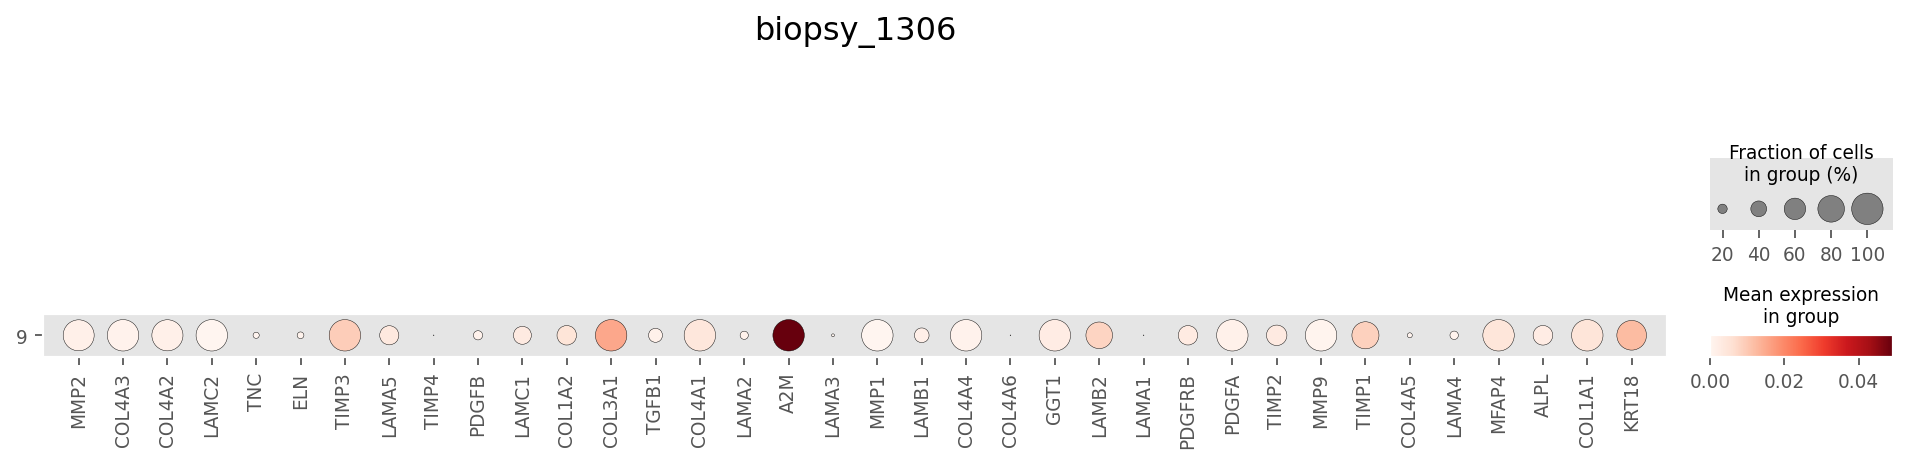

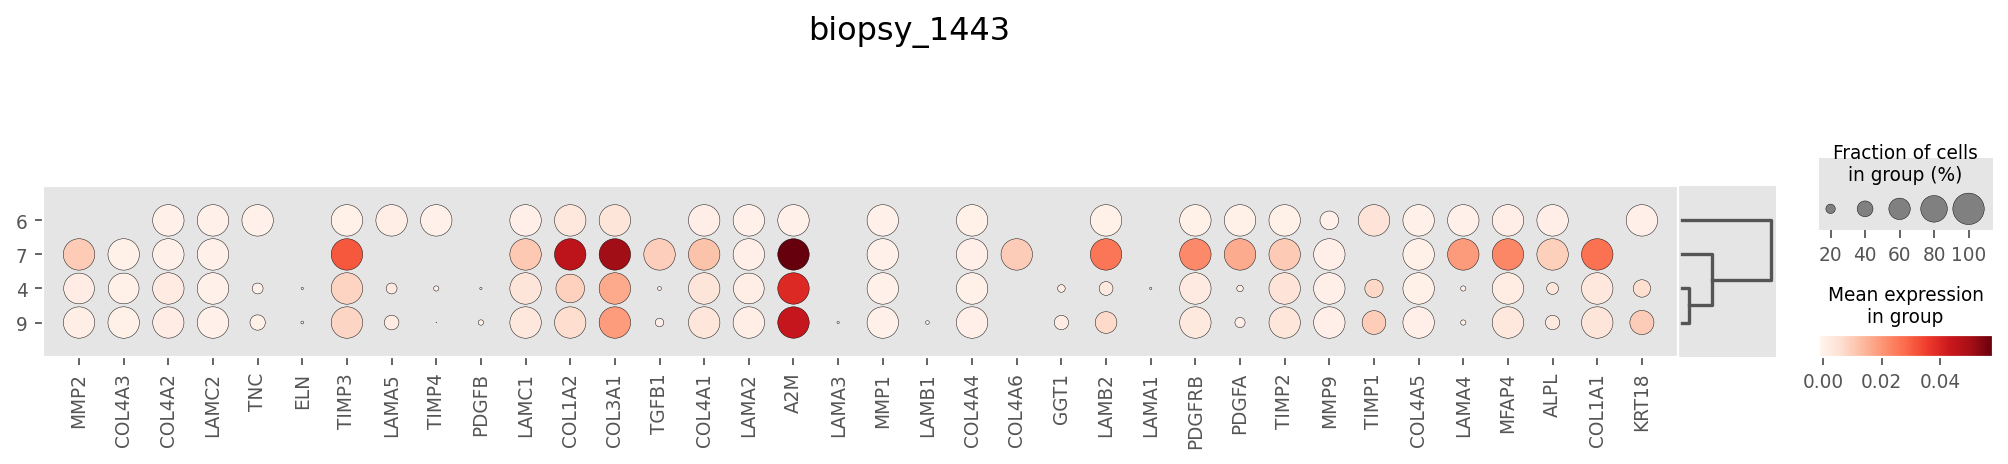

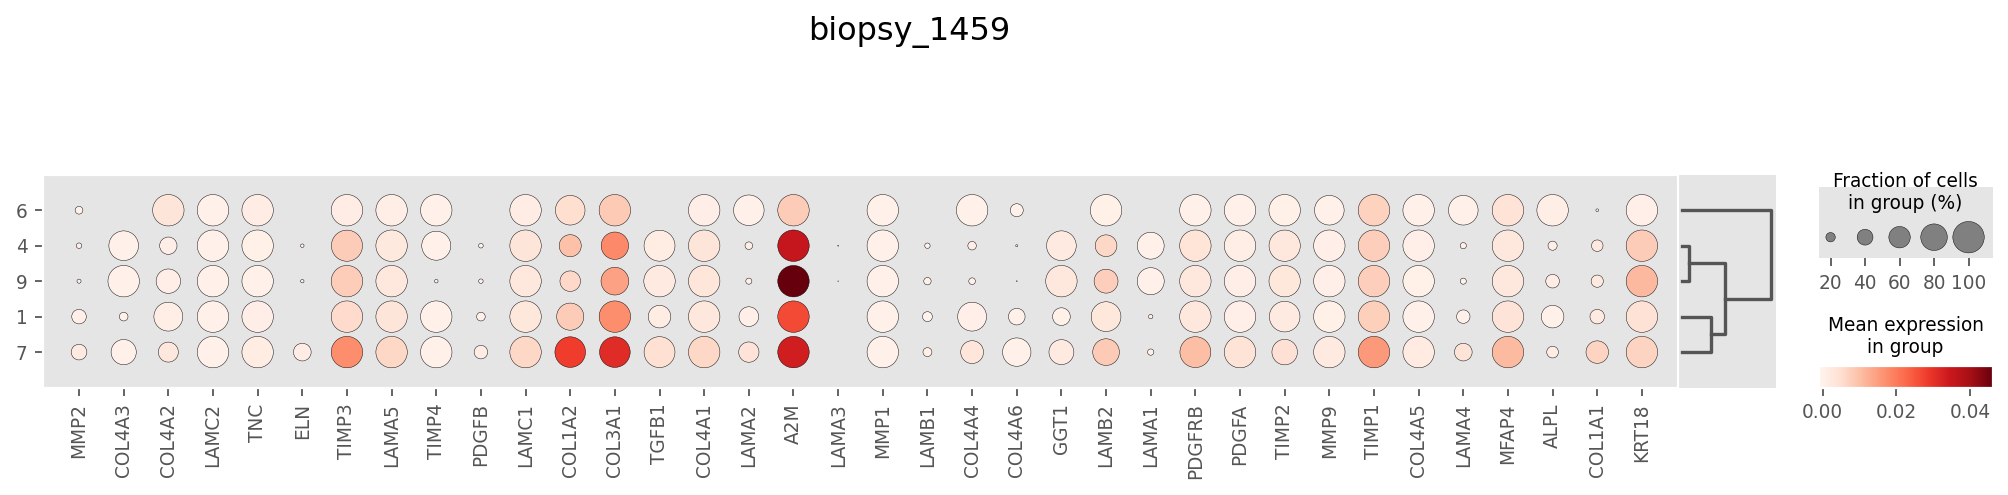

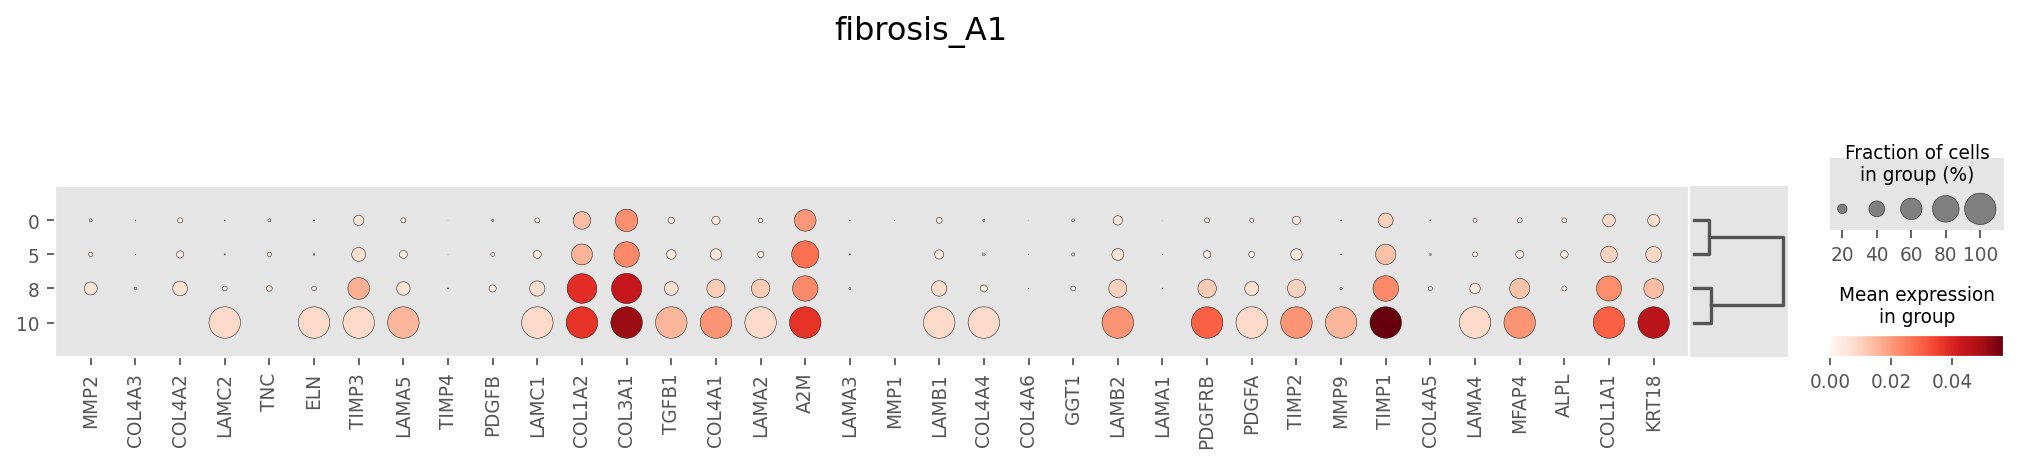

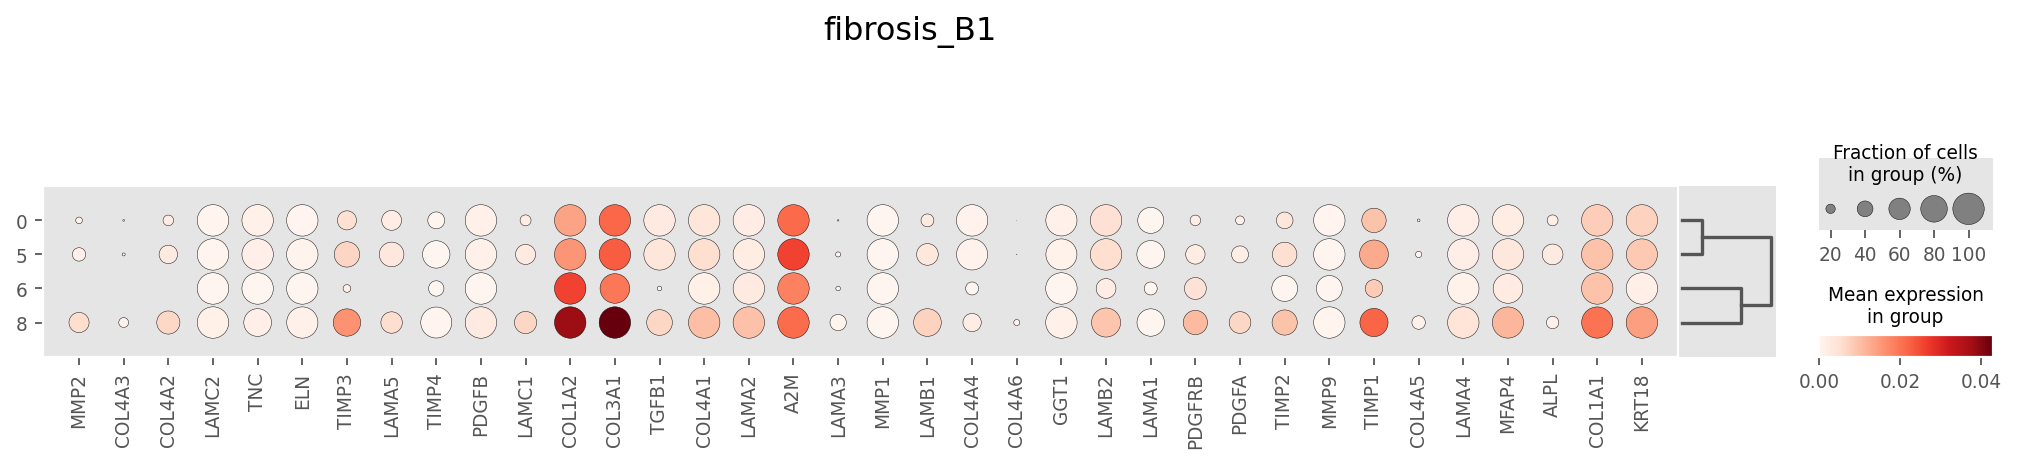

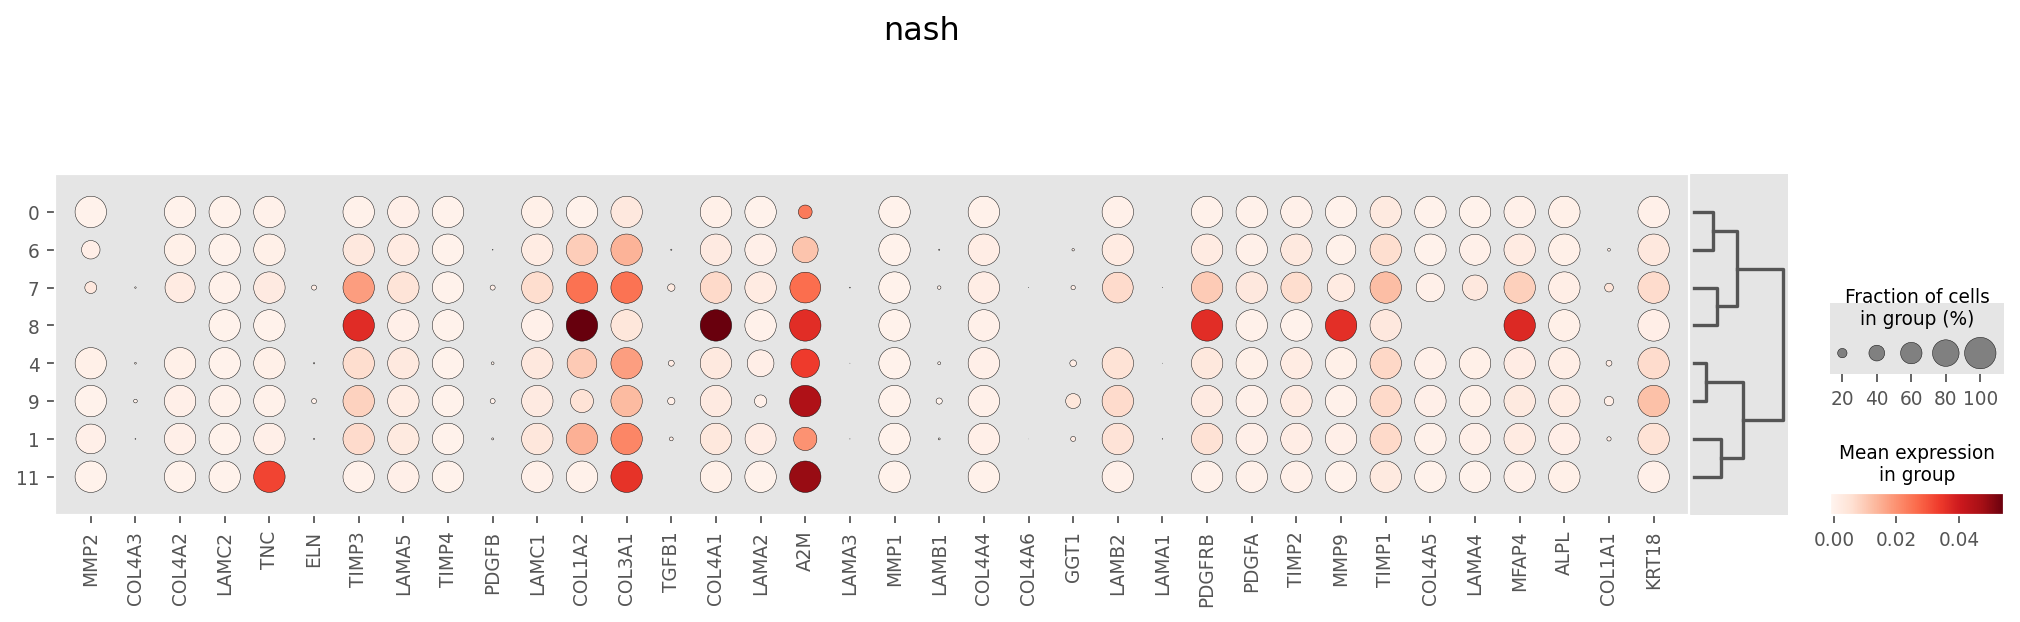

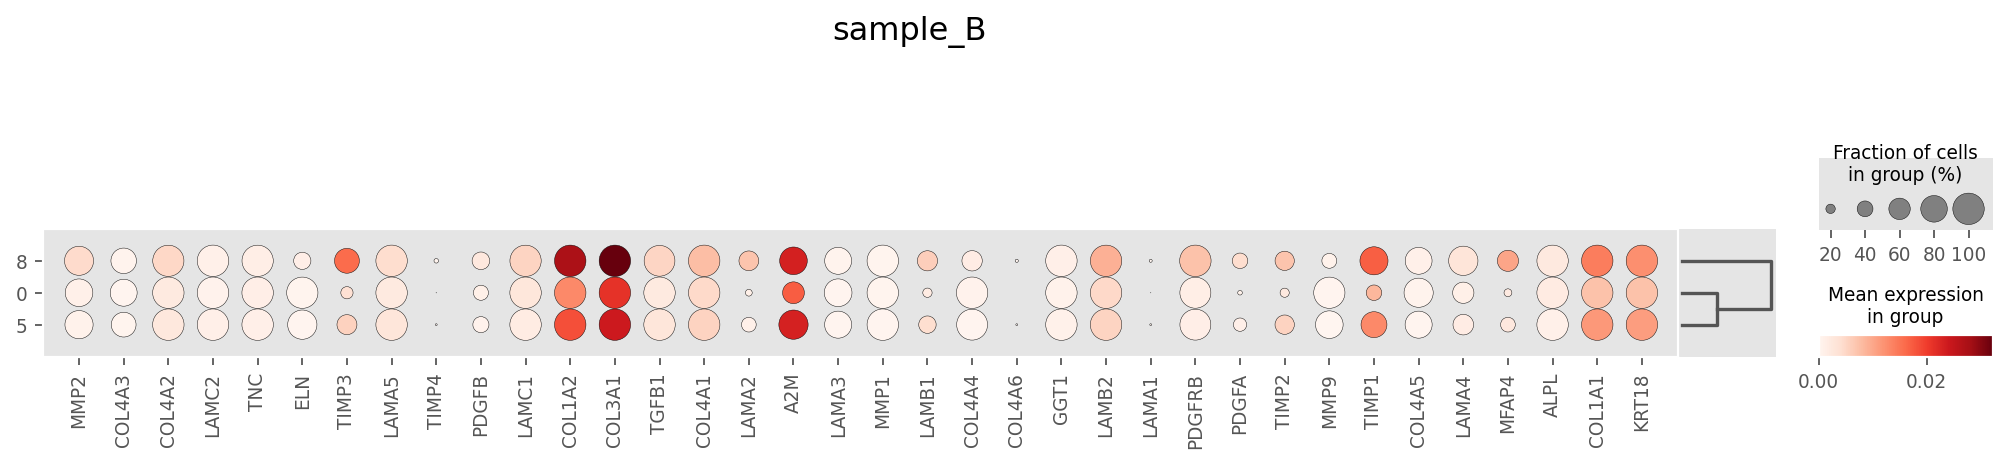

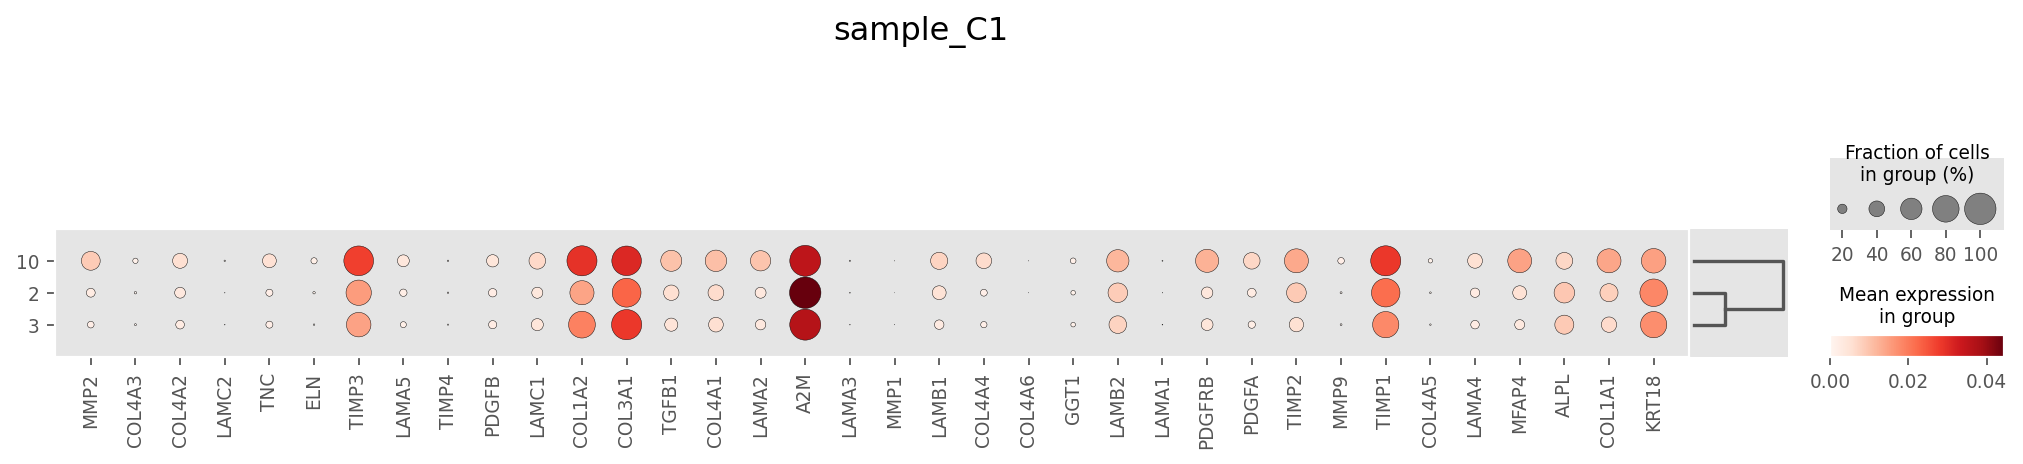

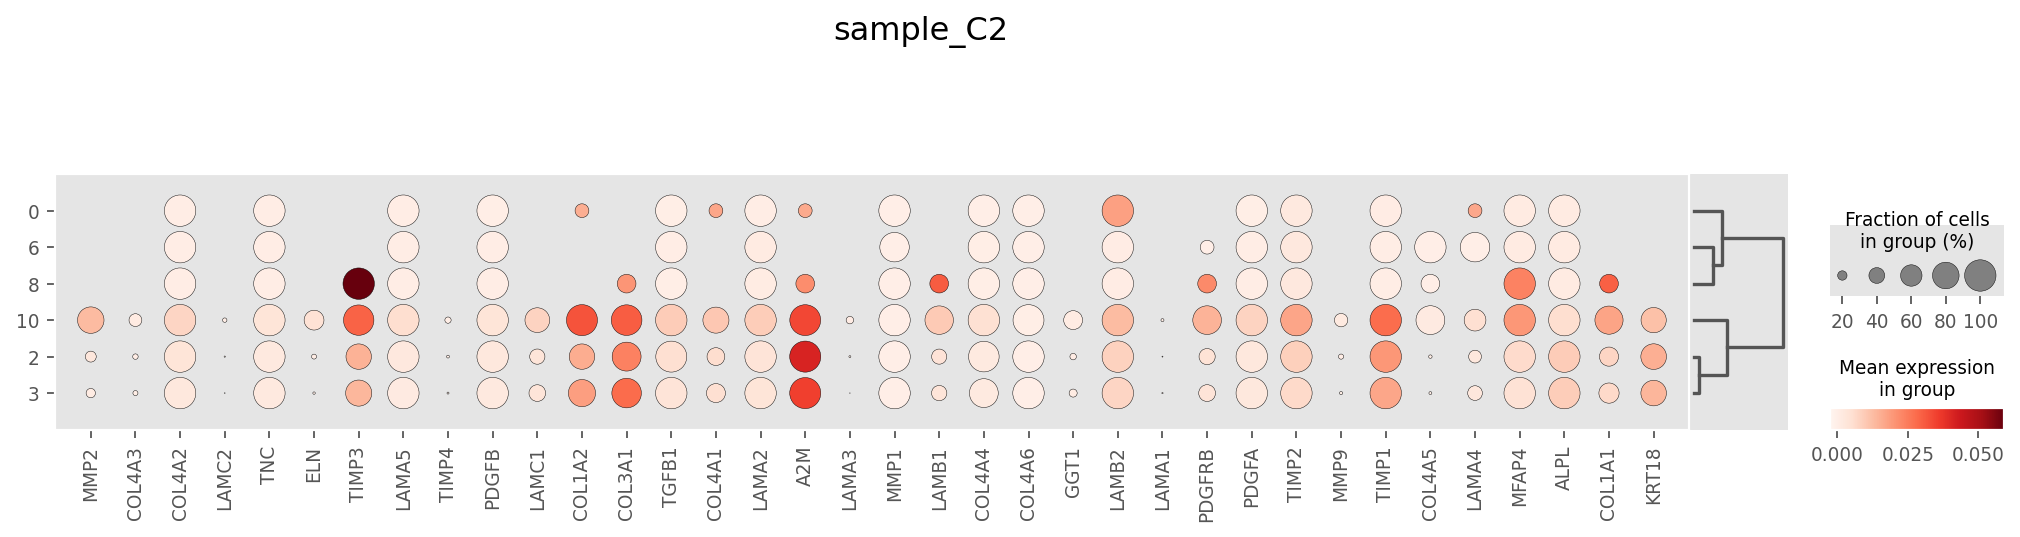

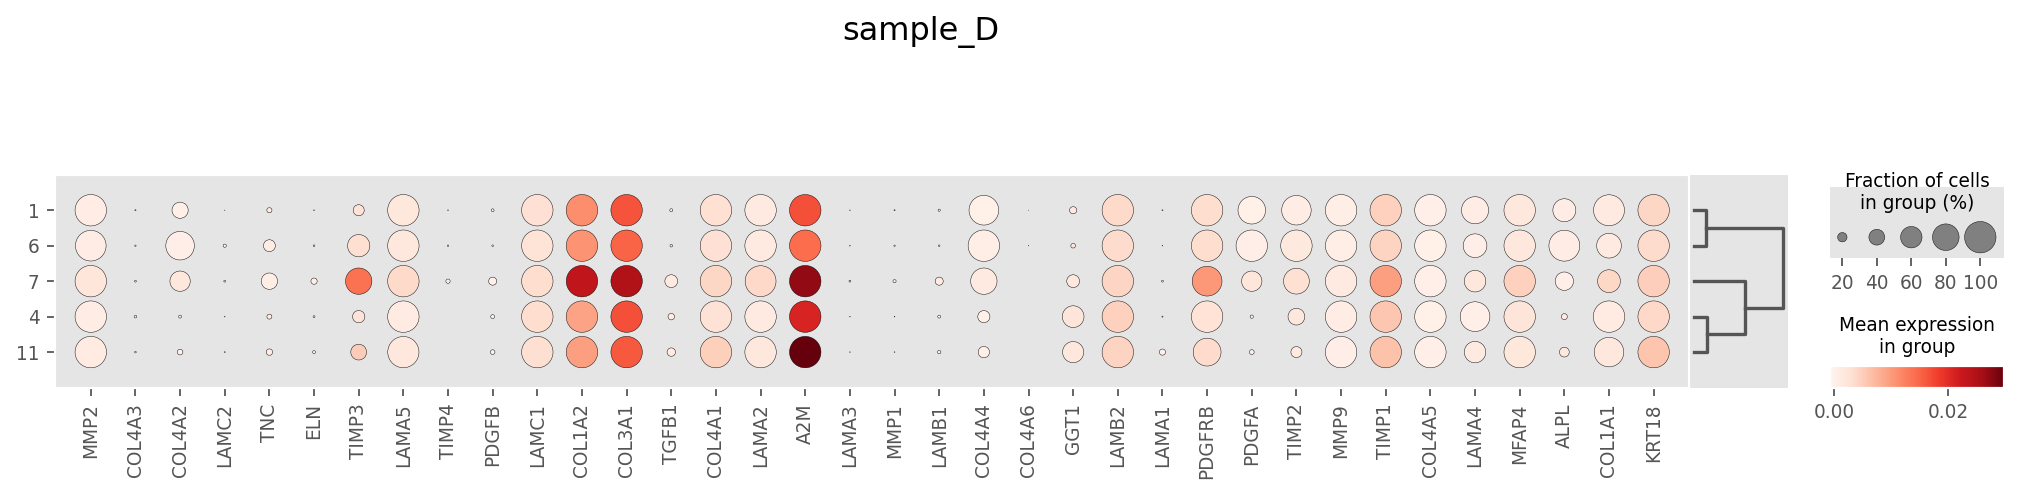

In [25]:
# plot fibrotic marker gene expression in each sample separately
for sp in adata_spatial.obs['sample'].unique():
    ad = adata_spatial[adata_spatial.obs['sample'] == sp,:].copy()
    clusters = ad.obs['clusters'].unique().tolist()
    if len(clusters) > 1:
        sc.tl.dendrogram(ad, groupby='clusters', use_rep='X_scanorama')
        sc.pl.dotplot(ad, fibro_genes, 'clusters',title=sp, dendrogram=True)
    else:
        sc.pl.dotplot(ad, fibro_genes, 'clusters',title=sp)

## 2.4 Count number of senescent cells in each cluster

In [29]:
def get_sene_spots(adata_list, genes, adata_spatial, label_col_name):
    # 1. get phenotype cells: senescence cells in this example
    all_sene_cells = []
    all_ring_cells = []  # this means the spots circling surround the senescnet spots.
    all_norm_cells = []
    # genes = ['CDKN1A','GLB1', 'HMGB1']
    for ad in adata_list:
        sp = list(ad.uns['spatial'].keys())[0]
        sene_cells, ring_cells, norm_cells = vis.filter_spots_by_gene(ad,genes)
        all_sene_cells.extend([f'{c}-{sp}' for c in sene_cells])
        all_ring_cells.extend([f'{c}-{sp}' for c in ring_cells])
        all_norm_cells.extend([f'{c}-{sp}' for c in norm_cells])
    
    adata_spatial.obs[label_col_name] = 'other'
    adata_spatial.obs.loc[all_ring_cells,label_col_name] = 'ring'
    adata_spatial.obs.loc[all_sene_cells,label_col_name] = 'sene'
    
genes = ['CDKN1A','GLB1', 'HMGB1'] # marker genes for senescence
label_col_name = 'sene_cluster'
get_sene_spots(adata_list, genes, adata_spatial, label_col_name)

Text(0.5, 1.0, 'senescent cells distribution in each cluster')

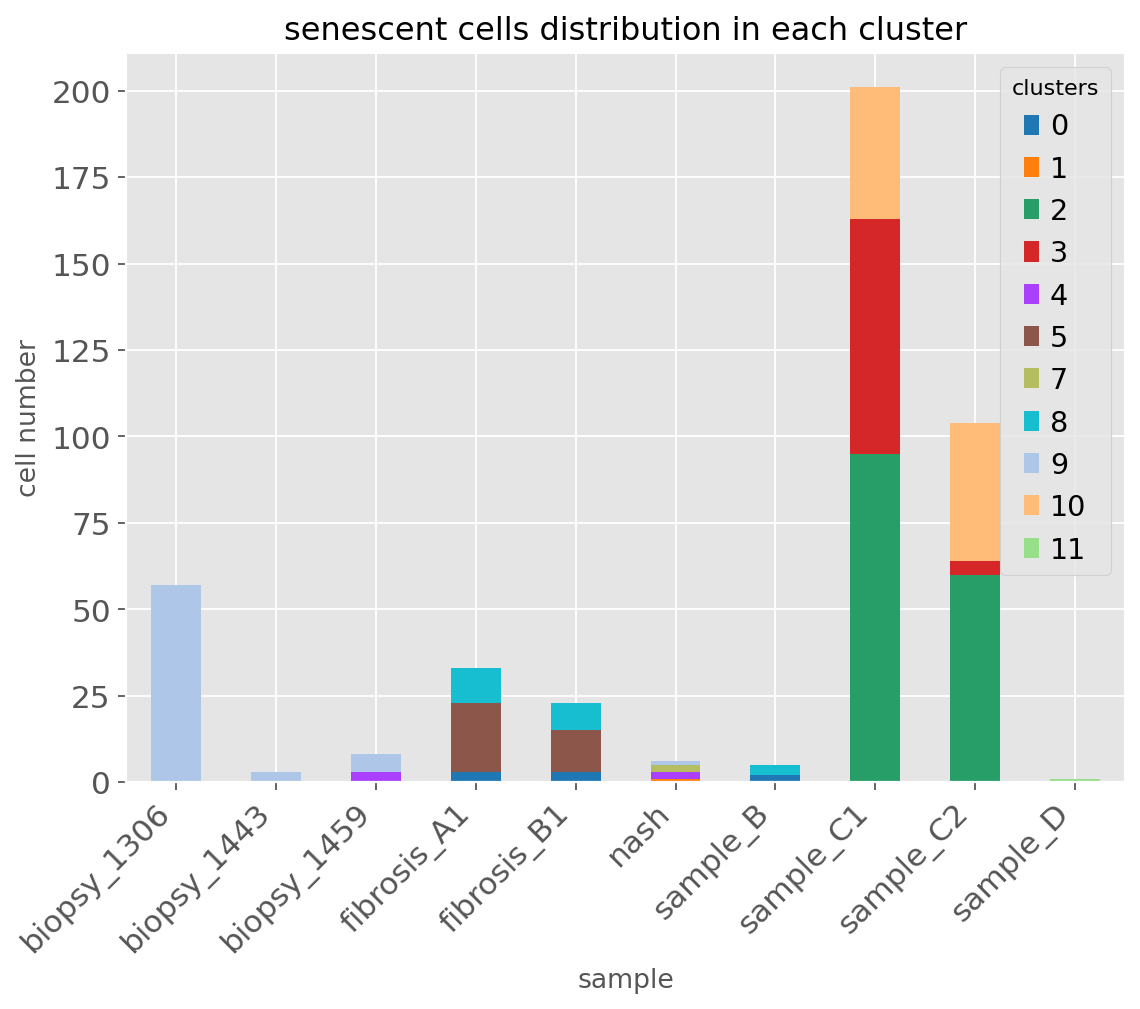

In [30]:
# senescnet cell distribution in each cluster
sene_cell_df = adata_spatial.obs.query('sene_cluster == "sene"').copy()
count_df = sene_cell_df[['sample','clusters']].value_counts().to_frame().reset_index()
count_df.rename(columns={0:'count'},inplace=True)
pivot_df = pd.pivot_table(data=count_df, index=['sample'], columns=['clusters'], values='count')
clusters_colors = dict(zip([str(i) for i in range(18)], adata_spatial.uns["clusters_colors"]))
ax = pivot_df.plot.bar(stacked=True, figsize=(8,6), rot=45, color=clusters_colors)
labels = ax.get_xticklabels()
_ = ax.set_xticklabels(labels, ha='right')
ax.set_ylabel('cell number')
ax.set_title('senescent cells distribution in each cluster')

In [32]:
sene_adata_fn = f'{work_path}/sene_adata.h5ad'
if not os.path.exists(sene_adata_fn):
    adata_spatial.write(sene_adata_fn)
else:
    adata_spatial = sc.read_h5ad(f'{work_path}/sene_adata.h5ad')
    adata_spatial.uns['log1p']['base'] = None

# 3 Donwstream analysis

In [32]:
adata_spatial.X[adata_spatial.X < 0] = 0

In [33]:
def de_genes_violin(adata_spatial, test_label, key, de_res_fn):
    ''' violin plot for significant genes
    * key: rank_gene_group key
    '''  
    
    all_sene_df = pd.read_csv(de_res_fn, sep='\t',header=0)
    all_sene_df, up_genes, dn_genes = vis.get_sig_de_genes(all_sene_df, test_label)

    print('number of up genes:',len(up_genes))
    print('number of down genes:',len(dn_genes))

    print('up genes overlap with sasp genes:', len(set(up_genes).intersection(sasp_genes)))
    print('dn genes overlap with sasp genes:', len(set(dn_genes).intersection(sasp_genes)))
    print('up genes overlap with senmyo genes:', len(set(up_genes).intersection(senmyo_genes)))
    print('dn genes overlap with senmyo genes:', len(set(dn_genes).intersection(senmyo_genes)))

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    plot_genes = all_sene_df[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[0], key=key, show=False, use_raw=True)

    plot_genes = all_sene_df.query(f'{test_label}_names in @sasp_genes')[f'{test_label}_names'].tolist()[:20]
    sc.pl.rank_genes_groups_violin(adata_spatial, groups=test_label, gene_names=plot_genes, ax=axes[1], key=key, show=False, use_raw=True)

## 3.1 DE analysis
### 3.1.1 senescnece spots in (8,10) VS normal spots in (0,1,6,11)
all senescent spots in high-fibrosis/steatosis clusters (8, 10) vs all of the normal cells in normal clusters (0, 1, 6, 11)

In [34]:
def assign_group_more_sene_norm(row):
    if row['sene_cluster'] == 'sene' and row['clusters'] in ['8','10']:
        return 'sene'
    elif row['sene_cluster'] == 'other' and row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_norm(row), axis=1)
de_key = 'more_sene_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['sene','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
more_sene_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/more_sene_VS_norm.tsv'
more_sene_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

other     15714
normal    12493
sene         99
Name: group4de, dtype: int64


number of up genes: 6406
number of down genes: 1542
up genes overlap with sasp genes: 18
dn genes overlap with sasp genes: 1
up genes overlap with senmyo genes: 59
dn genes overlap with senmyo genes: 8


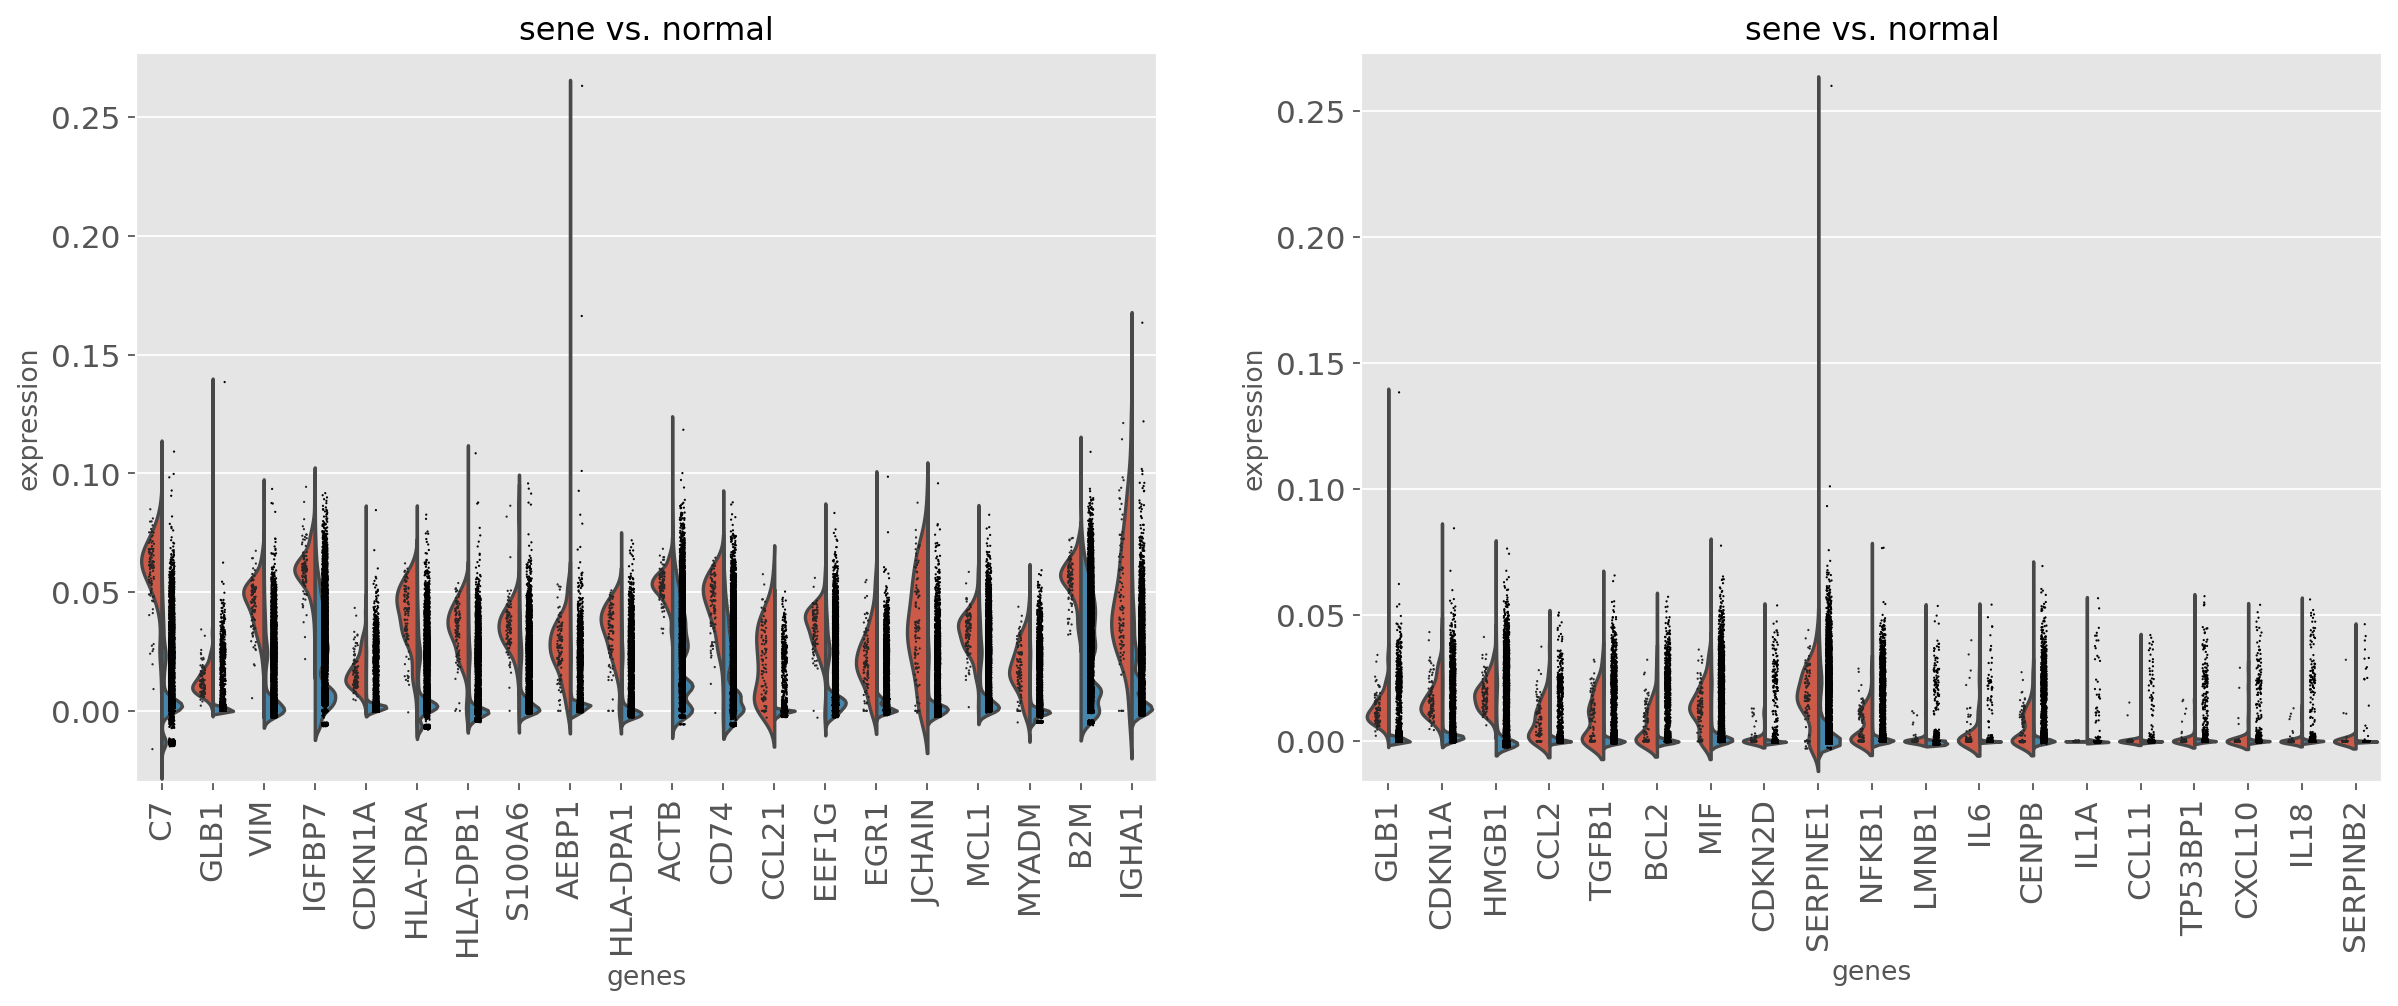

In [35]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_norrm(row), axis=1)
de_fn = f'{de_path}/more_sene_VS_norm.tsv'
de_genes_violin(adata_spatial, 'sene', 'more_sene_VS_norm', de_fn)

## 3.1.2 severe senescent spots in (8,10) VS less severe senescent spots in (0,1,6, 11)
all senescent spots in high-fibrosis/steatosis clusters (8, 10) vs senescence spots in other clusters (0, 1, 6, 11)

In [36]:
def assign_group_more_sene_less_sene(row):
    if row['sene_cluster'] == 'sene' and row['clusters'] in ['8','10']:
        return 'sene'
    elif row['sene_cluster'] == 'sene' and row['clusters'] in ['0','1','6','11']:
        return 'sene_in_norm'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_less_sene(row), axis=1)
de_key = 'more_sene_VS_less_sene'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='sene_in_norm', method='wilcoxon', groups=['sene','sene_in_norm'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
more_sene_vs_less_sene_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/more_sene_VS_less_sene.tsv'
more_sene_vs_less_sene_df.to_csv(de_fn, sep='\t',index=False)

other           28197
sene               99
sene_in_norm       10
Name: group4de, dtype: int64


number of up genes: 120
number of down genes: 19
up genes overlap with sasp genes: 1
dn genes overlap with sasp genes: 0
up genes overlap with senmyo genes: 3
dn genes overlap with senmyo genes: 0


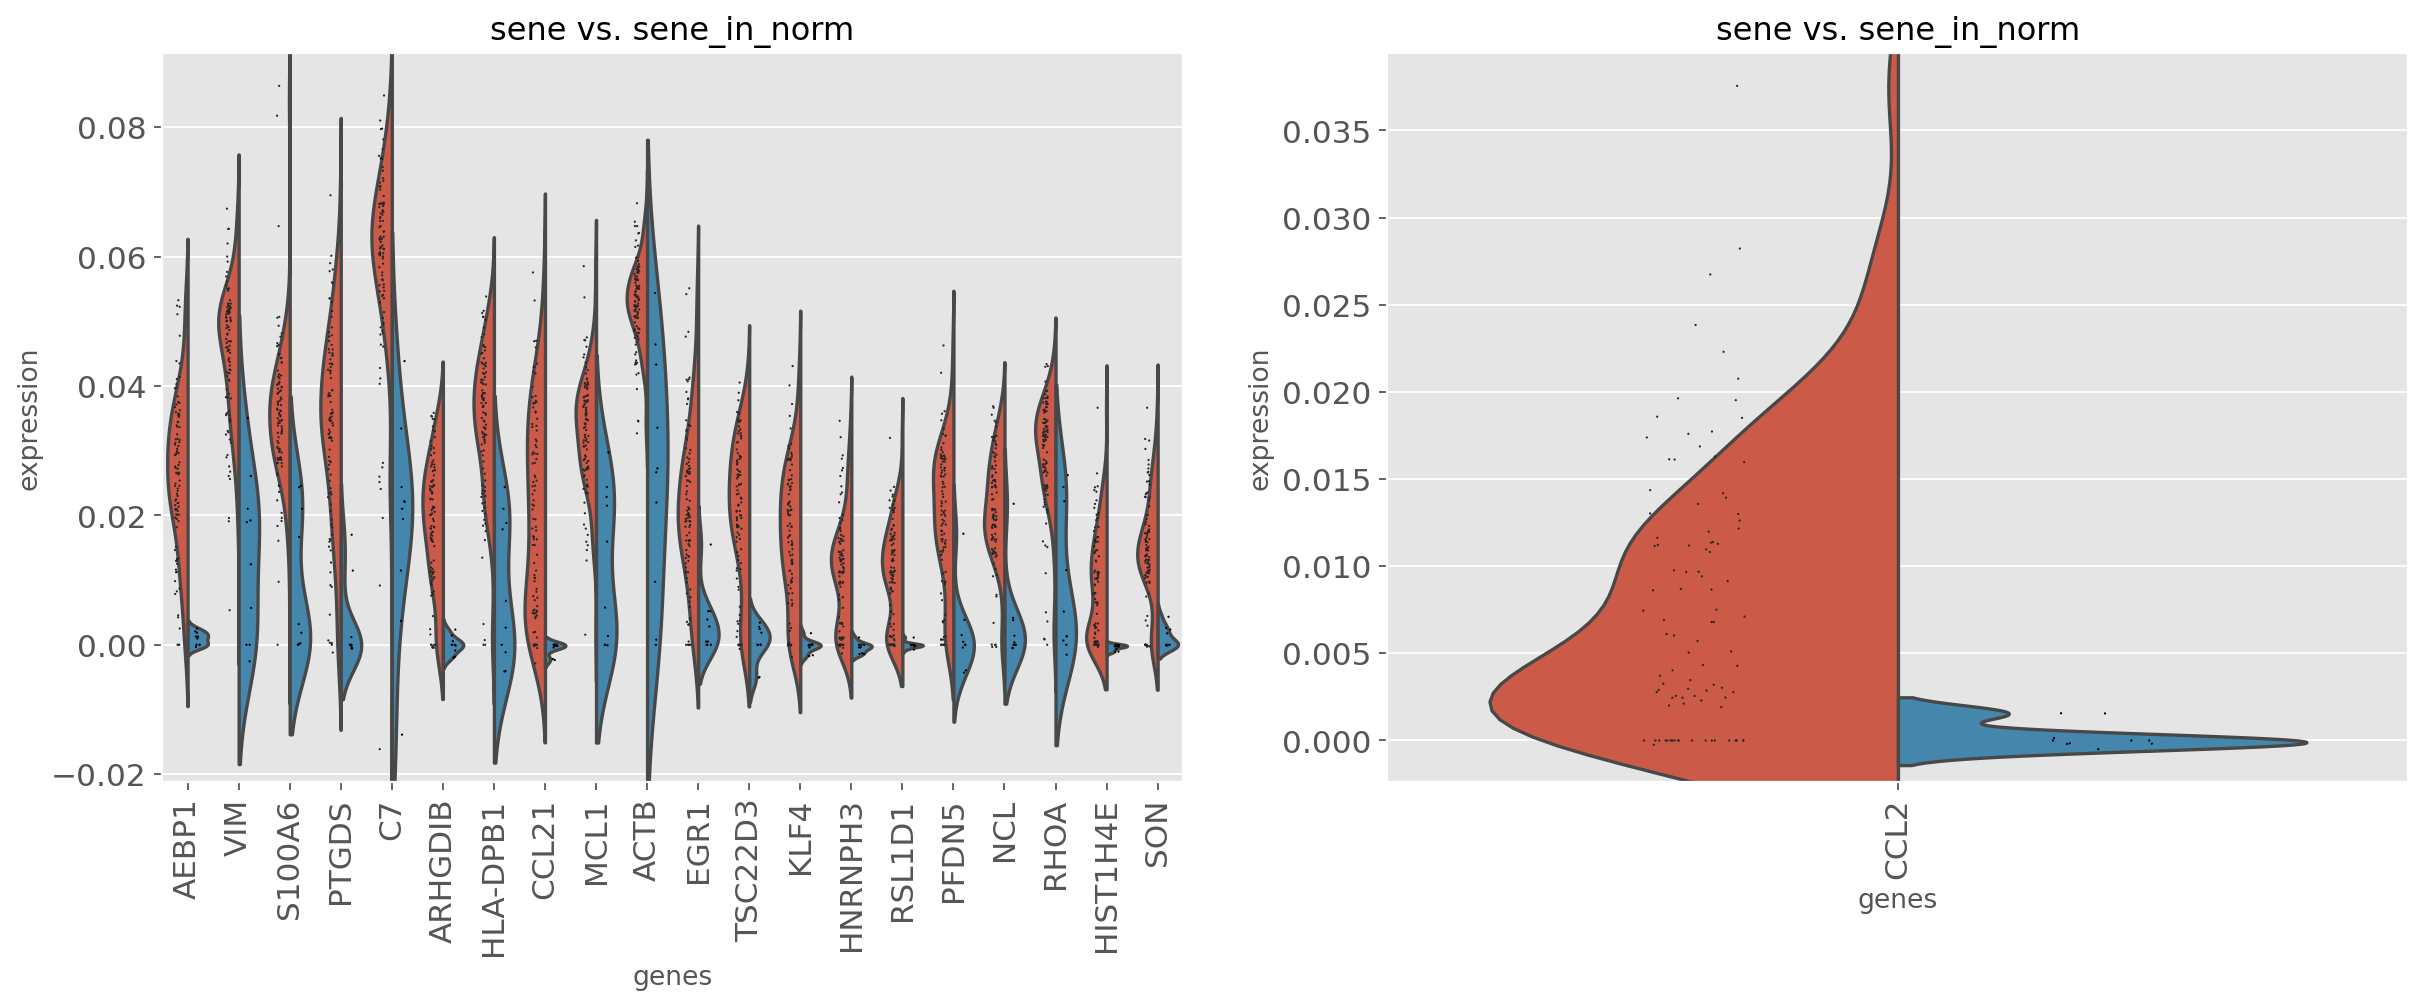

In [37]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_more_sene_less_sene(row), axis=1)
de_fn = f'{de_path}/more_sene_VS_less_sene.tsv'
de_genes_violin(adata_spatial, 'sene', 'more_sene_VS_less_sene', de_fn)

## 3.1.3 all sene VS normal
all senescent spots in all clusters vs senescence spots in other clusters (0, 1, 6, 11)

In [38]:
def assign_group_all_sene_norm(row):
    if row['sene_cluster'] == 'sene':
        return 'sene'
    elif row['sene_cluster'] == 'other' and row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_all_sene_norm(row), axis=1)
de_key = 'all_sene_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['sene','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
all_sene_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/all_sene_VS_norm.tsv'
all_sene_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

other     15372
normal    12493
sene        441
Name: group4de, dtype: int64


number of up genes: 5404
number of down genes: 1815
up genes overlap with sasp genes: 14
dn genes overlap with sasp genes: 2
up genes overlap with senmyo genes: 52
dn genes overlap with senmyo genes: 10


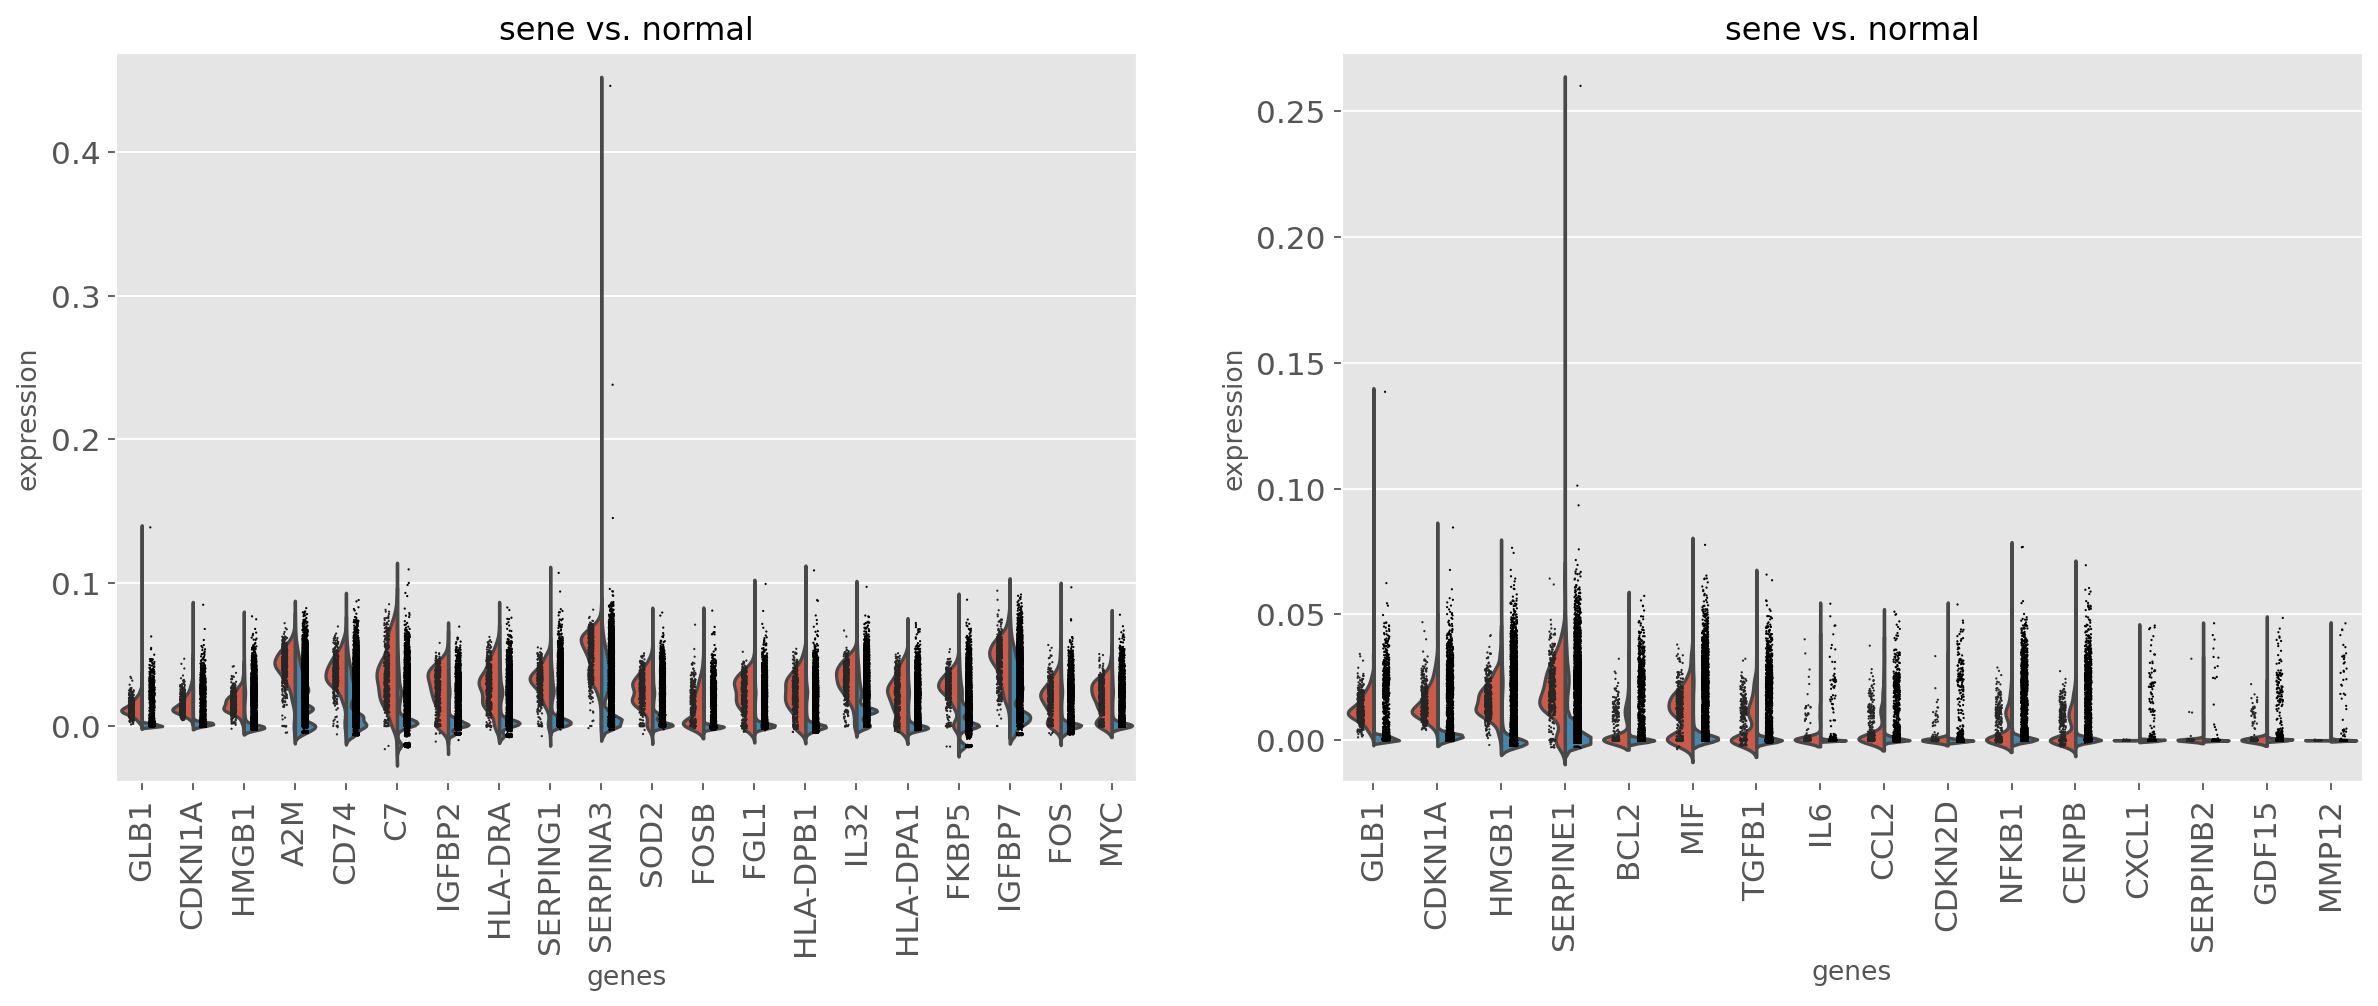

In [39]:
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_all_sene_norm(row), axis=1)
de_fn = f'{de_path}/all_sene_VS_norm.tsv'
de_genes_violin(adata_spatial, 'sene', 'all_sene_VS_norm', de_fn)

## 3.1.4 all firbo clusters VS normal clusters
all fibrotic clusters (8, 10, 2, 3, 5, 7) VS normal clusters (0, 1, 6, 11)

In [40]:
def assign_group_fibro_norm(row):
    if row['clusters'] in ['8','10','2','3','5','7']:
        return 'fibro'
    elif row['clusters'] in ['0','1','6','11']:
        return 'normal'
    else:
        return 'other'
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_fibro_norm(row), axis=1)
de_key = 'fibro_VS_norm'
sc.tl.rank_genes_groups(adata_spatial, 'group4de', reference='normal', method='wilcoxon', groups=['fibro','normal'], pts=True, key_added=de_key, use_raw=False)
print(adata_spatial.obs['group4de'].value_counts())
# extract de results
fibro_vs_norm_df = vis.get_rank_genes_de_res(adata_spatial, de_key)
# output to file
de_path = f'{work_path}/f02_de'
os.makedirs(de_path, exist_ok=True)
de_fn = f'{de_path}/fibro_VS_norm.tsv'
fibro_vs_norm_df.to_csv(de_fn, sep='\t',index=False)

normal    12996
fibro     11789
other      3521
Name: group4de, dtype: int64


number of up genes: 2949
number of down genes: 1781
up genes overlap with sasp genes: 7
dn genes overlap with sasp genes: 0
up genes overlap with senmyo genes: 32
dn genes overlap with senmyo genes: 7


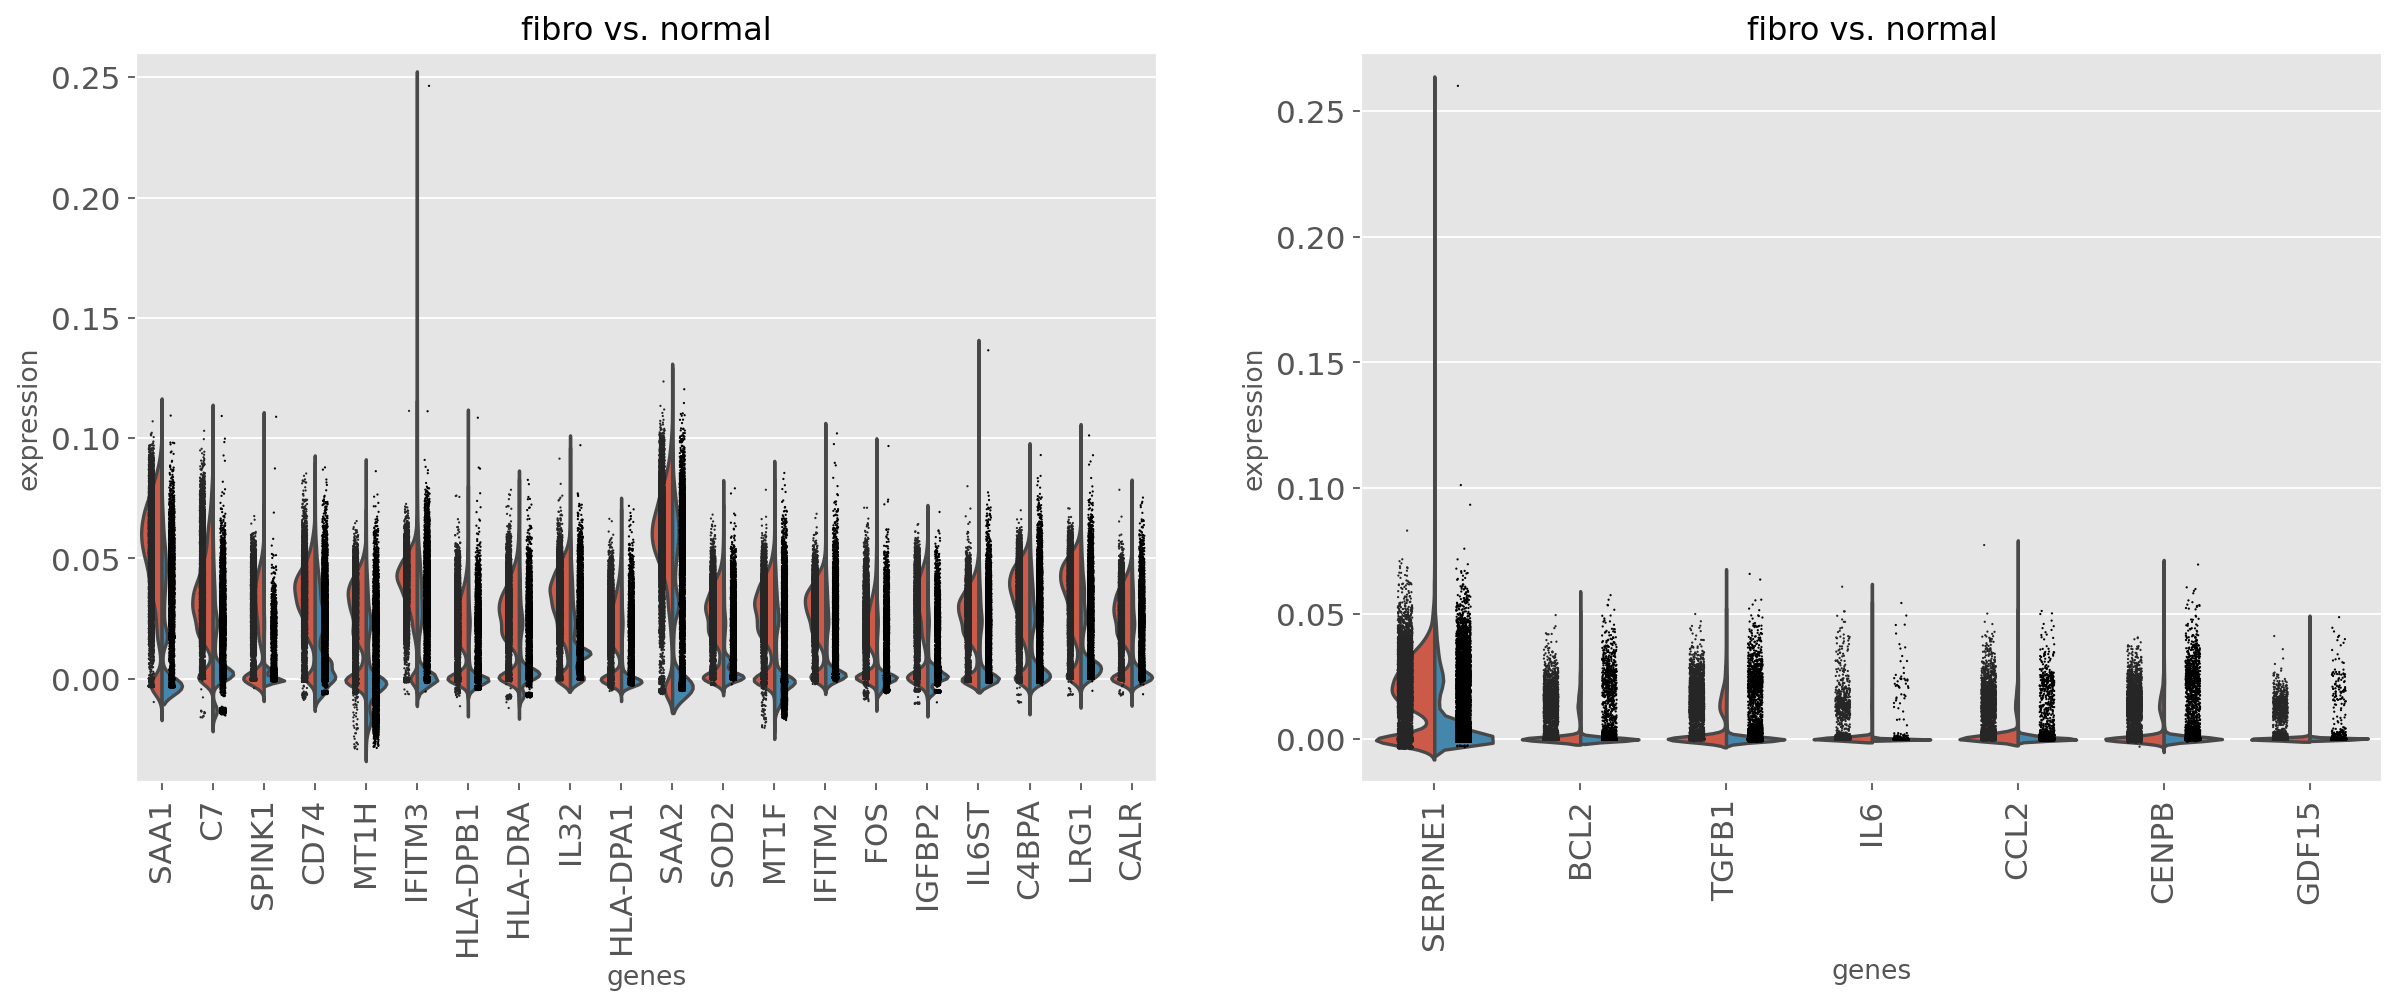

In [41]:
# plot violin plot for DE genes
adata_spatial.obs['group4de'] = adata_spatial.obs.apply(lambda row: assign_group_fibro_norm(row), axis=1)
de_fn = f'{de_path}/fibro_VS_norm.tsv'
de_genes_violin(adata_spatial, 'fibro', 'fibro_VS_norm', de_fn)